# PandaTeam2023
**P**eter **A**ndré **N**icolas **D**iego **A**li Team

This notebook aims to investigate and elucidate key facets of our datasets, carry out preprocessing, and conduct preliminary analysis. The initial section of the notebook encompasses data loading and incorporates general preprocessing techniques utilized throughout the entire notebook.

---
**Contents of notebook:**
- [Data Processing](#Data-Processing)
  - [Loading data](#Loading-data)
  - [Merging the dataframes](#Merging-the-dataframes)
- [Actor recognition](#Part-1:-Actors-Recognition)
    - [Remove actors who played in less than 5 movies](#Remove-actors-who-played-in-less-than-5-movies)
    - [Normalization of movie's ratings and revenues](#Normalization-of-movie's-ratings-and-revenues)
    - [Compute Actor Recognition Coefficient for each (Movie, Actor) pair](#Compute-Actor-Recognition-Coefficient-for-each-Movie-Actor-pair)
    - [Compute Actor Recognition Coefficient for every Actor every Year](#Compute-Actor-Recognition-Coefficient-for-every-Actor-every-Year)
    - [Expand the dataset to include entries for all actors in each year](#Expand-the-dataset-to-include-entries-for-all-actors-in-each-year)
    - [Recognition of Preceding Years](#Recognition-of-Preceding-Years)
    - [General recognition](#General-recognition)
    - [Number of well-recognized actors per year](#Number-of-well-recognized-actors-per-year)
- [Actor Recognition Longevity](#Part-2:-Actor-Recognition-Longevity)
    - [Visualizing Average Span of Recognition through the years](#Visualizing-Average-Span-of-Recognition-through-the-years)
    - [Recognition coefficient of specific actors](#Recognition-coefficient-of-specific-actors)
- [Composition of actors in terms of gender over time](#Part-3:-Composition-of-actors-in-terms-of-gender-over-time)
    - [Loading data](#Loading-data)
    - [Preprocessing](#Preprocessing)
    - [Gender analysis  among recognized actors](#Gender-analysis-among-recognized-actors)
- [Composition of actors in terms of ethnicity over time](#Part-4:-Composition-of-actors-in-terms-of-ethnicity-over-time)
    - [Preprocessing](#Preprocessing)
    - [Actors Ethnicities](#Actors-Ethnicities)
    - [Analyze recognized actors ethnicities](#Analyze-recognized-actors-ethnicities)

## Part 0: Data Processing

### Loading data

In [52]:
# !git clone https://github.com/jtloong/chow-test.git
# !pip install ./chow-test

Processing ./chow-test
  Preparing metadata (setup.py) ... done
  Created wheel for chow-test: filename=chow_test-1.0-py3-none-any.whl size=1973 sha256=dac2930a702fa4f732df15bd9bb4a23dae7556d0625d220f85cd59d8292af6d8
  Stored in directory: /root/.cache/pip/wheels/3e/2a/e5/3e1b1d9aad40d20e9187c72b511754f84dc016311169058e65
Successfully built chow-test


In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
import seaborn as sns
from scipy import stats
import json
import requests
import string
import scipy.stats as st
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from helpers import *
import chow_test
%matplotlib inline

The data folder has to be downloaded and extracted from the following [link](https://drive.google.com/drive/folders/1z3b524gW2u75Pr1ahKqpq0fDVbv2BMnG?usp=sharing). The content of this folder should be put in the data folder

In [ ]:
character = pd.read_csv('./data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
movie = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv('./data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
IMDb_data = pd.read_csv('./data/IMDb/akas.tsv', sep='\t', dtype={7: str}, usecols=['titleId', 'title'])
IMDb_ratings = pd.read_csv('./data/IMDb/ratings.tsv', sep='\t', usecols=['tconst', 'averageRating'])
TheMoviesDataset = pd.read_csv('./data/TheMoviesDataset/movies_metadata.csv')
mojo_int1000 = pd.read_csv('./data/Mojo/boxofficemojointernationaltop1000.tsv', sep='\t')
mojo_us1000 = pd.read_csv('./data/Mojo/boxofficemojoustop1000.tsv', sep='\t')
inflation = pd.read_excel('./data/Inflation/Inflation-data.xlsx', sheet_name='hcpi_a')
imdb_actor_name = pd.read_csv('./data/IMDb/name.basics.tsv', sep='\t', usecols=['primaryName', 'birthYear'])
IMDb_title = pd.read_csv('./data/IMDb/title.basics.tsv', sep='\t', usecols=['originalTitle', 'startYear'])

In [6]:
# Adding column names
movie_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"]
character_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
plot_summaries_columns = ["Wikipedia movie ID", "Plot summary"]
movie.columns = movie_columns
character.columns = character_columns

### Merging the dataframes
Several datasets are used in this notebook in addition to the [CMU Movie Summary Corpus](https://www.cs.cmu.edu/~ark/personas//):
- The [IMDb dataset](https://developer.imdb.com/non-commercial-datasets/) to get access to movie ratings and actor dates of birth.
- The [World Bank inflation dataset](https://www.worldbank.org/en/research/brief/inflation-database) to adapt Movie box office in order to account for temporal variations in the value of the US dollar.
- The [Mojo dataset](https://www.kaggle.com/datasets/kalilurrahman/top-box-office-revenue-data-english-movies/data?select=boxofficemojoustop1000.tsv) are used to add missing Box office and release date values.
- The [The Movies Datset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv) are used to add missing Box office and release date values.

The dataframes corresponding to these datasets are merged into one dataframe.

#### Merging CMU Movie Corpus dataframe with IMDB dataframe

In [7]:
# Merge movies and actors based on the Movie ID
movie_actor = pd.merge(movie, character, how="left", on=["Wikipedia movie ID","Freebase movie ID"])

# Merge IMDb ratings with the corresponding Movie title
IMDb_combined = pd.merge(IMDb_data,IMDb_ratings,left_on='titleId',right_on='tconst')

# Getting lower cases movie title to merge on titles
movie_actor['title_lower'] = movie_actor['Movie name'].str.lower()
IMDb_combined['title_lower'] = IMDb_combined['title'].str.lower()

# Average different ratings for same Movie
IMDb_combined_mean = IMDb_combined[['title_lower','averageRating']].groupby(['title_lower']).mean()
IMDb_combined_mean.reset_index(inplace=True)

# Merge IMDb ratings with the movies and actors dataframe
movie_actor_IMDb = pd.merge(movie_actor,IMDb_combined_mean[['title_lower','averageRating']],on='title_lower', how='left')

#### Adding missing Box office values and missing release dates from other datasets ([Mojo](https://www.kaggle.com/datasets/kalilurrahman/top-box-office-revenue-data-english-movies/data?select=boxofficemojoustop1000.tsv), [The Movies Datset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv) & [IMDb](https://developer.imdb.com/non-commercial-datasets/))

In [8]:
# Add missing Box office values and missing release dates from other datasets (Mojo & The Movies Datset)

# Define a list of datasets to merge
datasets = [
    (TheMoviesDataset, 'original_title', 'revenue','release_date'),
    (mojo_us1000, 'Movie', 'Lifetime Gross','Year'),
    (mojo_int1000, 'Title', 'Worldwide Lifetime Gross','Year'),
    (IMDb_title, 'originalTitle', 'None', 'startYear')
]

datanames = ['TheMoviesDataset', 'mojo_us1000', 'mojo_int1000', 'IMDb']

print("Before merging:")
# Show that number of Nan values decreases
print("Numer of missing Box office values",movie_actor_IMDb['Movie box office revenue'].isna().sum())
print("Numer of missing release dates values",movie_actor_IMDb['Movie release date_x'].isna().sum())
print("")

i = 0
# Iterate through the datasets and merge
for dataset, movie_column, revenue_column, date_column in datasets:
    print("After merging with", datanames[i], ":")
    i = i+1
    # Getting lower cases movie title to merge on titles
    dataset = dataset.copy()
    dataset['title_lower'] = dataset[movie_column].str.lower()

    # Convert date to datetime, replacing errors with NaT
    dataset[date_column] = pd.to_datetime(dataset[date_column], errors='coerce')

    # Create a datetime object for the threshold date
    date_threshold = dt(2013, 1, 1)

    # Filter the DataFrame based on the threshold date
    dataset = dataset[dataset[date_column] < date_threshold]

    if revenue_column != 'None':
        # Remove rows that have revenue = 0
        dataset=dataset[dataset[revenue_column]!=0.0]
        # Grouping same movie names of dataset
        dataset = dataset.groupby('title_lower').agg({f'{revenue_column}': 'mean', f'{date_column}': 'first'}).reset_index()
        # Add missing values
        movie_actor_IMDb = pd.merge(movie_actor_IMDb, dataset[['title_lower', revenue_column, date_column]], on='title_lower', how='left')
        movie_actor_IMDb['Movie box office revenue'] = movie_actor_IMDb['Movie box office revenue'].fillna(movie_actor_IMDb[revenue_column])
        movie_actor_IMDb['Movie release date_x'] = movie_actor_IMDb['Movie release date_x'].fillna(movie_actor_IMDb[date_column])
        movie_actor_IMDb.drop([revenue_column,date_column], axis=1,inplace=True)
    else:
        # Grouping same movie names of dataset
        dataset = dataset.groupby('title_lower').agg({f'{date_column}': 'first'}).reset_index()
        # Add missing values
        movie_actor_IMDb = pd.merge(movie_actor_IMDb, dataset[['title_lower', date_column]], on='title_lower', how='left')
        movie_actor_IMDb['Movie release date_x'] = movie_actor_IMDb['Movie release date_x'].fillna(movie_actor_IMDb[date_column])
        movie_actor_IMDb.drop([date_column], axis=1,inplace=True)


    # Show that number of Nan values decreases
    print("Numer of missing Box office values",movie_actor_IMDb['Movie box office revenue'].isna().sum())
    print("Numer of missing release dates values",movie_actor_IMDb['Movie release date_x'].isna().sum())
    print("")

movie_actor_IMDb.drop_duplicates(subset=['Actor name', 'Movie name', 'Movie release date_x'], inplace=True)

Before merging:
Numer of missing Box office values 366874
Numer of missing release dates values 13190

After merging with TheMoviesDataset :
Numer of missing Box office values 347373
Numer of missing release dates values 12929

After merging with mojo_us1000 :
Numer of missing Box office values 346736
Numer of missing release dates values 12912

After merging with mojo_int1000 :
Numer of missing Box office values 346431
Numer of missing release dates values 12899

After merging with IMDb :
Numer of missing Box office values 346431
Numer of missing release dates values 3784



#### Dealing with NaN values

To address missing data in `Movie release date` and `Movie box office revenue` without significant information loss, NaN values are replaced with zero, allowing retention of valuable data points in the dataset.

In [9]:
# Convert Nans to 0
movie_actor_IMDb['Movie box office revenue'] = movie_actor_IMDb['Movie box office revenue'].fillna(0)
movie_actor_IMDb['Movie release date_x'] = movie_actor_IMDb['Movie release date_x'].fillna(0)

Moreover, there are some `Actor name` missing. Since our analysis relies on actors, if the actor's name is missing, then the corresponding row wouldn't be useful. Therefore we remove rows in which the actor's name is missing

In [10]:
missing_names = movie_actor_IMDb['Actor name'].isna().sum()
print('In {} rows the actors name is missing'.format(missing_names))

In 18137 rows the actors name is missing


In [11]:
# Remove rows that have missing actor names
movie_actor_IMDb.dropna(subset='Actor name', inplace=True)

#### Adapt Box office with inflation

The [World Bank inflation dataset](https://www.worldbank.org/en/research/brief/inflation-database) is an additional dataset, it contains inflation rates over time and location. However, it has to be adapted in order to be used in our analysis e.g. adapt the time-span, fix the location of the inflation.

To account for temporal variations in the value of the US dollar, an adjustment is applied to box office revenues by normalizing them against cumulative inflation. This involves dividing the movie's box office revenue by the cumulative inflation factor, ensuring a comparable scale over time.

#### Prepare the inflation dataframe

In [12]:
# Considering inflation in the US as a baseline
inflation_us = inflation[inflation['Country Code']=='USA']

# Melt the DataFrame to reshape it
melted_inflation = pd.melt(inflation_us, id_vars=['Country Code', 'IMF Country Code', 'Country', 'Indicator Type', 'Series Name'], var_name='Year', value_name='Inflation')

# Convert the "Year" column to numeric
melted_inflation['Year'] = pd.to_numeric(melted_inflation['Year'], errors='coerce')

# Select relevant columns
melted_inflation = melted_inflation[['Year','Inflation']]
melted_inflation = melted_inflation.iloc[:-2]

# Create a DataFrame with years from 1914 to 1969 and 'inflation' set to 0 (To account for missing inflation values)
additional_years = pd.DataFrame({'Year': range(1914, 1970), 'Inflation': 0})

# Add a year 0 for missing years
additional_years = additional_years._append({'Year':0,'Inflation':0}, ignore_index=True)

# Merge the additional_years DataFrame with melted_inflation (Adding 0 inflation to missing years)
melted_inflation = pd.concat([melted_inflation, additional_years], ignore_index=True, sort=False)

# Sort the DataFrame
melted_inflation = melted_inflation.sort_values(by='Year')

# Calculate cumulative inflation to adapt revenues further
melted_inflation['Cumulative Inflation'] = (melted_inflation['Inflation'].astype(float)/100 + 1).cumprod()

melted_inflation.head(2)

,Year,Inflation,Cumulative Inflation
109,0.0,0,1.0
53,1914.0,0,1.0


In [13]:
# Convert date to datetime, replacing errors with NaT
movie_actor_IMDb['Movie release date_x'] = pd.to_datetime(movie_actor_IMDb['Movie release date_x'], errors='coerce')

# Make sure that the movies that are kept were indeed released before 2012
date_threshold = dt(2013, 1, 1)
movie_actor_IMDb = movie_actor_IMDb[movie_actor_IMDb['Movie release date_x'] < date_threshold]

# Extract year from Movie release date
movie_actor_IMDb["Year"] = pd.DatetimeIndex(movie_actor_IMDb["Movie release date_x"]).year

movie_actor_IMDb_inflation = pd.merge(movie_actor_IMDb,melted_inflation[['Year','Cumulative Inflation']])

# Calculate Adapted Movie Box Office Revenue
movie_actor_IMDb_inflation['Adapted Movie box office revenue'] = movie_actor_IMDb_inflation['Movie box office revenue']/movie_actor_IMDb_inflation['Cumulative Inflation']

The current dataframe structure consists of unique rows corresponding to movie-actor pairs.

For each row, the important data for further analysis is:
- The Inflation Adapted Movie box office revenue
- The rating of the movie
- The release date of the movie
- The age of the actor and his date of birth
- The ethnicity of the actor
- The gender of the actor

---
Now that the data has been preprocessed, we can finally start with our analyis. This preliminary analysis serves as an initial exploration of the dataset, laying the groundwork for more in-depth investigations into the research questions outlined in the `ReadMe`. The analysis is segmented into four primary focus areas:
- Actors recognition
- Actors recognition longevity
- Composition of actors in terms of gender over time
- Composition of actors in terms of ethnicity over time

It is important to note that this analysis serves as a preliminary step, offering a foundation for deeper exploration. As we progress, more sophisticated analyses can be conducted to address the specific research questions in more detail.

---

## Part 1: Actors Recognition

The following analysis delves into Actors Recognition. Actors Recognition is defined based on the following key criteria : the rating and box ofice revenus of movies in which the actor has played.

In [14]:
# Conserve relevant columns
columns_to_conserve = ['Actor name', 'Wikipedia movie ID', 'Movie name', 'Movie release date_x', 'averageRating',\
                       'Adapted Movie box office revenue','Actor date of birth','Actor gender',\
                        'Actor ethnicity (Freebase ID)','Actor age at movie release' ,'Year', 'Character name']

conserved_df = movie_actor_IMDb_inflation[columns_to_conserve].copy()

conserved_df.columns = ['Actor Name', 'Wikipedia movie ID', 'Movie name', 'Date', 'Rating',\
                       'Revenue','Actor date of birth','Actor gender',\
                        'Actor ethnicity (Freebase ID)','Actor age at movie release' ,'Year', 'Character name']

conserved_df = conserved_df.sort_values(by='Year', ascending=False)
conserved_df.head(2)

,Actor Name,Wikipedia movie ID,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year,Character name
407054,Bhavana Menon,36025071,Ozhimuri,2012-09-07,7.6,0.0,1986-06-06,F,NaN,26.0,2012,NaN
409375,Shahrukh Khan,30471278,Student of the Year,2012-10-19,5.2,0.0,1965-11-02,M,/m/09743,46.0,2012,NaN


### Remove actors who played in less than 5 movies
As an initial preprocessing measure, we filter out actors with fewer than 5 movie appearances. This step is undertaken to optimize computational efficiency, as it is assumed that actors with a limited number of film credits may not possess significant recognition.

In [15]:
# Remove actors who have less than 5 movies
actor_movie_counts = conserved_df['Actor Name'].value_counts()
actors_with_5_or_more_movies = actor_movie_counts[actor_movie_counts >= 5].index
filtered_df = conserved_df[conserved_df['Actor Name'].isin(actors_with_5_or_more_movies)]

### Normalization of movie's ratings and revenues

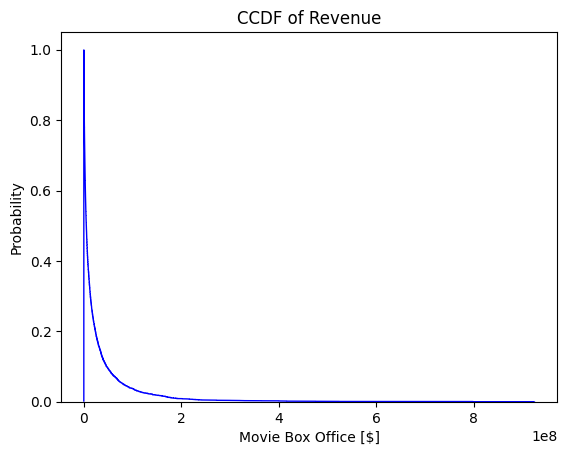

In [16]:
# Showing that revenue is heavy-tailed right skewed

# Remove zeros Revenues (missing revenues)
filtered_df_no_0s = filtered_df[filtered_df['Revenue'] > 1]

revenue_array = plt.hist(filtered_df_no_0s['Revenue'], bins=1000000, density=True, cumulative=-1,
                               color='blue', histtype='step', label="Revenue")
plt.xlabel('Movie Box Office [$]')
plt.ylabel('Probability')
plt.title('CCDF of Revenue')
plt.show()

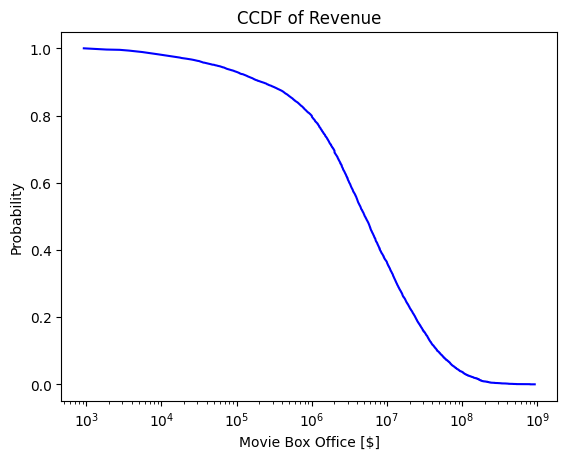

In [17]:
plt.plot(revenue_array[1][1:], revenue_array[0], label="Left-handed pitchers", color='blue')
plt.xscale('log')
plt.xlabel('Movie Box Office [$]')
plt.ylabel('Probability')
plt.title('CCDF of Revenue')
plt.show()

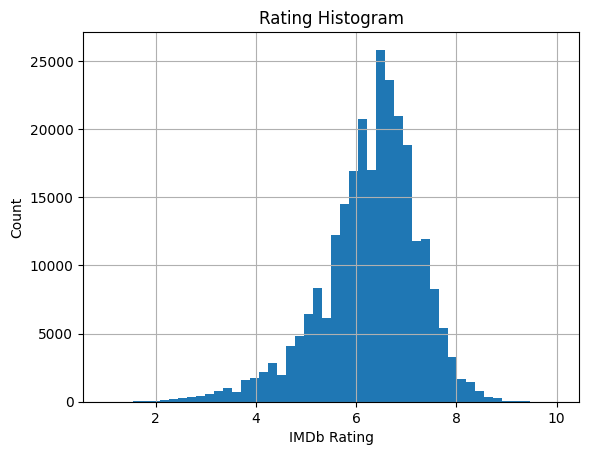

In [18]:
# Showing that rating is normal-like
filtered_df.hist(['Rating'],bins=50)
plt.xlabel('IMDb Rating')
plt.ylabel('Count')
plt.title('Rating Histogram')
plt.show()

As we can see from the previous plots:
- The Revenue of movies follows a right-skewed heavy-tailed distribution
- The Rating of movies follows a normal-like distribution

In order to normalize/scale these distributions, we use relevant techniques for each distribution:
- For a heavy-tailed distribution, we apply a logarithmic transformation
- For a normal distribution, we apply Z-score normalization

After these two normalizations, we then apply Min/Max scaling to have the same scale for the two distributions.

In [19]:
# Assuming filtered_df is your DataFrame
columns_to_scale = ['Revenue', 'Rating']
actor_popularity_rank = filtered_df.copy()

# Z-score normalization for Rating then min max scaling
actor_popularity_rank['Rating'] = (actor_popularity_rank['Rating'] - actor_popularity_rank['Rating'].mean()) / actor_popularity_rank['Rating'].std()
actor_popularity_rank['Rating'] = (actor_popularity_rank['Rating']-actor_popularity_rank['Rating'].min())/(actor_popularity_rank['Rating'].max()-actor_popularity_rank['Rating'].min())

# log normalization of Revenue then min max scaling
actor_popularity_rank.loc[actor_popularity_rank['Revenue'] < 1, 'Revenue'] = 1
actor_popularity_rank['Revenue'] = actor_popularity_rank['Revenue'].apply(lambda x: np.log(x))
actor_popularity_rank['Revenue'] = (actor_popularity_rank['Revenue']-actor_popularity_rank['Revenue'].min())/(actor_popularity_rank['Revenue'].max()-actor_popularity_rank['Revenue'].min())

# Sort by 'Year' in descending order
actor_popularity_rank = actor_popularity_rank.sort_values(by='Year', ascending=False)

# Display the DataFrame
actor_popularity_rank.head(2)

,Actor Name,Wikipedia movie ID,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year,Character name
407054,Bhavana Menon,36025071,Ozhimuri,2012-09-07,0.733333,0.0,1986-06-06,F,NaN,26.0,2012,NaN
413961,Christian Slater,33466334,The Power of Few,2012-01-01,0.455556,0.0,1969-08-18,M,/m/09vc4s,42.0,2012,Clyde


### Actor's importance in movie

We estimate the actor's importance in a given movie by analysing the plot summary of the movie and counting the number of times this actor is mentioned or referenced in the summary. We divide that value by the highest number of mentions to give an estimate between 0 and 1 of how important the character is important in the movie.

Counting the number of appearences in the plot summary:

In [20]:
plot_summaries_columns = ["Wikipedia movie ID", "Plot summary"]
plot_summaries.columns = plot_summaries_columns
plot_summaries

,Wikipedia movie ID,Plot summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [21]:
def count_words_in_text(word_list, text):
    # The function now counts each occurrence of any part of the character's name
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    words_in_text = text.split()
    word_count = {word: 0 for word in word_list}

    for word in word_list:
        # Splitting the character name into individual words
        parts = word.lower().split()
        # Counting each occurrence of any part of the name
        for part in parts:
            word_count[word] += words_in_text.count(part)

    return word_count

# Prepare a list to collect data
data = []

# Iterating over each movie
for movie_id in movie['Wikipedia movie ID']:
    # Extracting character names for this movie, excluding NaNs or non-string values
    characters = character[character['Wikipedia movie ID'] == movie_id]['Character name']
    characters = [name for name in characters if isinstance(name, str)]

    # Retrieving the plot summary for this movie, if available
    plot_summary_df = plot_summaries[plot_summaries['Wikipedia movie ID'] == movie_id]
    if not plot_summary_df.empty:
        plot_summary = plot_summary_df.iloc[0]['Plot summary']

        # Counting occurrences of each character name in the plot summary
        word_counts = count_words_in_text(characters, plot_summary)

        # Collecting the results
        for character_name, count in word_counts.items():
            data.append({"Wikipedia movie ID": movie_id,
                         "Character name": character_name,
                         "Repetitions": count})
    else:
        # Handling the case where plot summary is not available
        for character_name in characters:
            data.append({"Wikipedia movie ID": movie_id,
                         "Character name": character_name,
                         "Repetitions": 0})

# Creating the DataFrame from the collected data
movie_character_counts = pd.DataFrame(data, columns=["Wikipedia movie ID", "Character name", "Repetitions"])

# Displaying the resulting DataFrame
display(movie_character_counts)

,Wikipedia movie ID,Character name,Repetitions
0,975900,Akooshay,0
1,975900,Lieutenant Melanie Ballard,8
2,975900,Desolation Williams,5
3,975900,Sgt Jericho Butler,3
4,975900,Bashira Kincaid,0
...,...,...,...
190281,913762,Maj. Nexx,0
190282,913762,Lord Feff,0
190283,913762,UN Spacy Commander,4
190284,913762,Silvie Gena,2


Computing the importance coefficient by dividing by the max number of times an actor is mentionned in the plot summary of the movie:

In [22]:
# Function to calculate coefficients
def calculate_coefficients(group):
    max_repetitions = group['Repetitions'].max()
    num_characters = len(group)

    if max_repetitions == 0:
        # If no character names appeared in the plot summary
        group['Importance Coefficient'] = 1 / num_characters
    else:
        # Divide the number of repetitions for each character by the total sum of repetitions
        group['Importance Coefficient'] = group['Repetitions'] / max_repetitions

    return group

movie_character_counts_coefs = movie_character_counts.copy()
# Applying the function to each group
movie_character_counts_coefs = movie_character_counts_coefs.groupby('Wikipedia movie ID').apply(calculate_coefficients)

# Resetting index if needed
movie_character_counts_coefs.reset_index(drop=True, inplace=True)

# Displaying the updated DataFrame
movie_character_counts_coefs.head(10)

<ipython-input-22-193a15c99f59>:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  movie_character_counts_coefs = movie_character_counts_coefs.groupby('Wikipedia movie ID').apply(calculate_coefficients)


,Wikipedia movie ID,Character name,Repetitions,Importance Coefficient
0,975900,Akooshay,0,0.000
1,975900,Lieutenant Melanie Ballard,8,1.000
2,975900,Desolation Williams,5,0.625
3,975900,Sgt Jericho Butler,3,0.375
4,975900,Bashira Kincaid,0,0.000
5,975900,Commander Helena Braddock,1,0.125
6,975900,Whitlock,0,0.000
7,975900,Big Daddy Mars,1,0.125
8,975900,Michael Descanso,0,0.000
9,975900,Uno,0,0.000


Merging back with the original dataframe:

In [23]:
# Merging the DataFrames
actor_rank_with_importance = pd.merge(actor_popularity_rank, movie_character_counts_coefs, how='left', on=["Wikipedia movie ID", "Character name"])

# Filling missing coefficients with 0
actor_rank_with_importance['Importance Coefficient'] = actor_rank_with_importance['Importance Coefficient'].fillna(0)

# Display the merged DataFrame
actor_rank_with_importance.head(2)

,Actor Name,Wikipedia movie ID,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year,Character name,Repetitions,Importance Coefficient
0,Bhavana Menon,36025071,Ozhimuri,2012-09-07,0.733333,0.0,1986-06-06,F,NaN,26.0,2012,NaN,NaN,0.000000
1,Christian Slater,33466334,The Power of Few,2012-01-01,0.455556,0.0,1969-08-18,M,/m/09vc4s,42.0,2012,Clyde,0.0,0.066667


### Compute Actor Recognition Coefficient for each (Movie, Actor) pair
After normalizing the features ( `Revenue` and `Rating`) crucial for determining a actor's recognition coefficient, the computation of the coefficient is initiated. In this analysis, we establish the Actor Recognition Coefficient as a weighted average incorporating both movie revenue, its rating as well as the actor's importance in the movie.

For every actor, we calculate the `Recognition Coefficient` in each movie they played in
 using the formula:

Let:

$$
MovieRecognition(actor, year, movie) = \frac{Revenue(actor, year, movie) + Rating(actor, year, movie)}{2}
$$

Then, the new recognition coefficient is defined as:

$$
Recognition(actor, year, movie) = MovieRecognition(actor, year, movie) \times (1 + ImportanceCoefficient(actor, year, movie))
$$


Where:
- $Recognition(actor,year,movie)$ is the actor's recognition coefficient in a specific year in a specific movie.
- $Revenue(actor,year,movie)$ is the movie's rating score after normalization.
- $Rating(actor,year,movie)$ is the movie's box office revenue score after normalization.

In [24]:
# Compute Actor Recognition Coefficient for each (Movie, Actor) pair
columns_to_scale = ['Revenue', 'Rating']

#  Weights can be adjusted
weights = [1, 1]
actor_popularity_movie_coef = actor_rank_with_importance.copy()

# Calculate weighted average of normalized rating and normalized revenue
movie_recognition = np.average(actor_rank_with_importance[columns_to_scale], axis=1, weights=weights)
actor_popularity_movie_coef['Movie Coefficient'] = movie_recognition
actor_popularity_movie_coef['Recognition Coefficient'] = movie_recognition * (1 + actor_rank_with_importance['Importance Coefficient'])

actor_popularity_movie_coef = actor_popularity_movie_coef.sort_values(by='Recognition Coefficient',ascending=False)
actor_popularity_movie_coef.head(2)

,Actor Name,Wikipedia movie ID,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year,Character name,Repetitions,Importance Coefficient,Movie Coefficient,Recognition Coefficient
13055,Leonardo DiCaprio,23270459,Inception,2010-07-08,0.870370,0.908129,1974-11-11,M,/m/09kr66,35.0,2010,Cobb,17.0,1.0,0.889250,1.778500
130252,Liam Neeson,65834,Schindler's List,1993-11-30,0.888889,0.882367,1952-06-07,M,/m/03bkbh,41.0,1993,Oskar Schindler,22.0,1.0,0.885628,1.771255


### Compute Actor Recognition Coefficient for every Actor every Year
Moving forward, the analysis proceeds to compute the Actor Recognition on a yearly basis, considering all the movies in which an actor has participated. This calculation involves determining the mean of the Recognition Coefficient across all the movies the actor has been part of in a given year.

In mathematical terms, the Recognition Coefficient per year is obtained by averaging the Recognition Coefficient for each movie:

$$  Recognition(actor,year) = \frac{1}{n} \sum_{i=1}^{n} Recognition(actor,year,{movie}_i) $$
Where:
- $Recognition(actor,year)$ is the actor's recognition coefficient in a specific year.
- $Recognition(actor,year,{movie}_i)$ represents the Recognition Coefficient for the i-th movie that actor has played in a specific year.
- $ n$ is the total number of movies the actor has participated in during a specific year.

In [25]:
# Compute Actor Recognition Coefficient for every Actor every Year
actor_movie_year = actor_popularity_movie_coef.groupby(['Actor Name', 'Year'])\
    .agg({'Recognition Coefficient': 'mean', 'Date': 'first','Actor date of birth': 'first',\
          'Actor gender': 'first','Actor ethnicity (Freebase ID)': 'first', 'Actor age at movie release':'mean'}).reset_index()
actor_movie_year = actor_movie_year.sort_values(by='Year',ascending=True)
actor_movie_year.head(2)

,Actor Name,Year,Recognition Coefficient,Date,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release
70627,Jacques Jaccard,1914,NaN,1914-01-05,1886-09-11,M,None,NaN
149098,Roscoe Arbuckle,1914,0.384457,1914-01-17,1887-03-24,M,/m/07bch9,NaN


### Expand the dataset to include entries for all actors in each year
We're creating a DataFrame with all actor-year combinations from 1914 to 2012, putting the Actor Recognition Coefficient to zero if the actor does not have films in the corresponding year

In [26]:
# Create a DataFrame with all actor-year combinations from 1914 to 2012
years = list(range(1914, 2013))

# Get unique actor names
actors = actor_movie_year['Actor Name'].unique()

# Create a MultiIndex DataFrame with all possible actor-year combinations
actor_year_combinations = pd.MultiIndex.from_product([actors, years], names=['Actor Name', 'Year']).to_frame(index=False)
actor_year_combinations.columns = ['Actor Name', 'Year']

# Merge the actor_year_combinations DataFrame with actor_movie_year to get the coefficients
all_actor_year = pd.merge(actor_year_combinations, actor_movie_year, on=['Actor Name', 'Year'], how='left')

# Fill missing values in the 'Recognition Coefficient' column with 0
all_actor_year['Recognition Coefficient'].fillna(0, inplace=True)

# Rename 'Recognition Coefficient' to 'Actor Year Coefficient'
all_actor_year.rename(columns={'Recognition Coefficient': 'Recognition Coefficient'}, inplace=True)

# Sort the result DataFrame
all_actor_year = all_actor_year.sort_values(by=['Year', 'Actor Name'], ascending=[True, True])

# Reset the index
all_actor_year.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
display(all_actor_year[['Actor Name', 'Year','Recognition Coefficient']])

,Actor Name,Year,Recognition Coefficient
0,50 Cent,1914,0.000000
1,A Martinez,1914,0.000000
2,A. Bromley Davenport,1914,0.000000
3,A. E. Matthews,1914,0.000000
4,A. J. Bowen,1914,0.000000
...,...,...,...
1903072,Şafak Sezer,2012,0.000000
1903073,Şener Şen,2012,0.000000
1903074,Žarko Potočnjak,2012,0.000000
1903075,Željko Ivanek,2012,0.728362


We now have a dataframe, that has a Recognition Coefficient value for each possible (Actor Name, Year) combination.


### Recognition of Preceding Years
Even if a certain actors does not play in any movie in a certain year, we consider that this actor would remain well-recognized to a certain extent during this year. To account for this effect, we add a certain fraction of the actor past year's Recognition Coefficient to the the current year's Recognition Coefficient.

We update the Recognition Coefficient with the following formula:

$$  Recognition(actor,year) = Recognition(actor,year) + C *Recognition(actor,year-1) $$

Where:
- $C$ is the previous year contribution, here $C=0.9$

In [27]:
# Recognition of Past Years
previous_year_contribution = 0.9

actor_year_df = all_actor_year.copy()
actor_year_df.sort_values(by=['Actor Name', 'Year'], inplace=True)

# Initialize a dictionary to store the previous 'Coefficient with Past' values for each actor
prev_b_values = {}

# Iterate through the rows of the DataFrame to compute the values for column 'Coefficient with Past'
for index, row in actor_year_df.iterrows():
    actor = row['Actor Name']
    year = row['Year']
    a_value = row['Recognition Coefficient']

    if actor in prev_b_values:
        b_value = a_value + previous_year_contribution * prev_b_values[actor]
    else:
        b_value = a_value  # If there is no previous value, use A(actor, year) as-is

    actor_year_df.at[index, 'Coefficient with Past'] = b_value
    prev_b_values[actor] = b_value

actor_year_df['Year'] = pd.to_numeric(actor_year_df['Year'])

# Display the resulting DataFrame
display(actor_year_df[['Actor Name','Recognition Coefficient']])

,Actor Name,Recognition Coefficient
0,50 Cent,0.000000
19223,50 Cent,0.000000
38446,50 Cent,0.000000
57669,50 Cent,0.000000
76892,50 Cent,0.278903
...,...,...
1826184,佐々木望,0.000000
1845407,佐々木望,0.000000
1864630,佐々木望,0.000000
1883853,佐々木望,0.000000


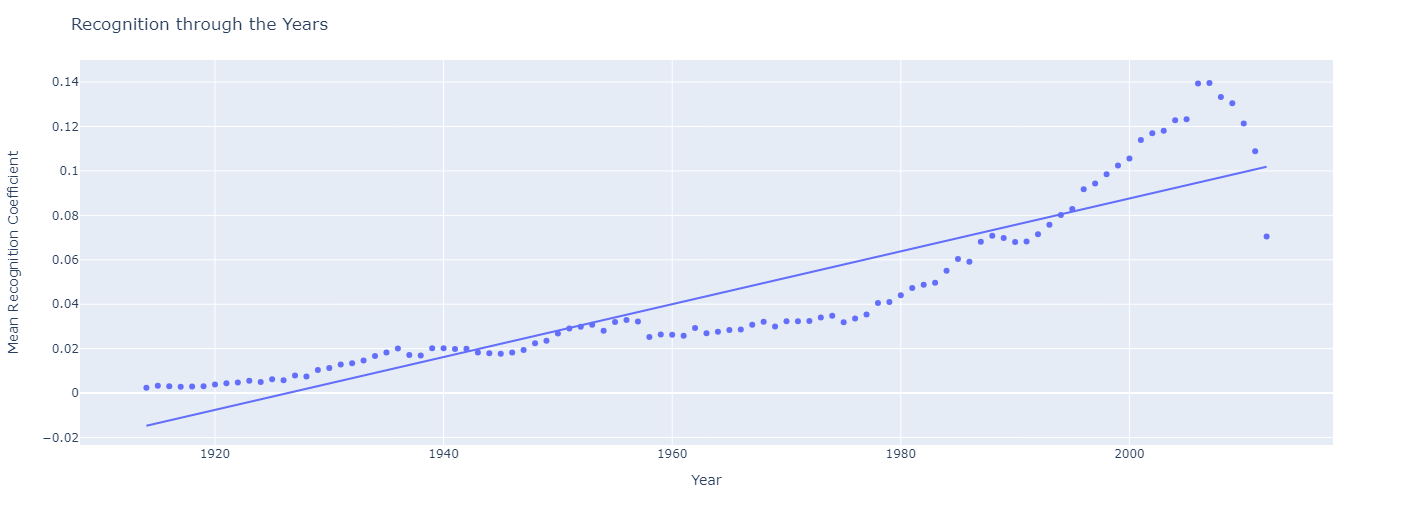

In [125]:
grouped_data = actor_year_df.groupby('Year')['Recognition Coefficient'].agg(['mean', 'std']).reset_index()

# Assuming grouped_data is a DataFrame with columns 'Year', 'mean', and 'std'
fig = px.scatter(grouped_data, x='Year', y='mean', trendline="ols", labels={'mean': 'Mean Recognition Coefficient'})

fig.update_layout(
    title='Recognition through the Years',
    xaxis_title='Year',
    yaxis_title='Mean Recognition Coefficient',
    hovermode='x unified',
    showlegend=True
)

# Save and show the figure
fig.write_html("htmls/recognition_plot.html")
fig.show()

From the above graph, it can be noticed that the average recognition coefficient tends to increase as the year increases. Besides, it can be noticed that the standard deviation also increases with the years.

In [54]:
p_value = chow_test.p_value(grouped_data['Year'][:1970-1914],grouped_data['mean'][:1970-1914],grouped_data['Year'][1970-1914:],grouped_data['mean'][1970-1914:])

# # Print results
# print("Chow Test Statistic:", chow_stat)
print("P-value:", p_value)

# Check if the difference is significant at a certain significance level (e.g., 0.05)
if p_value < 0.05:
    print("The difference is significant. Reject the null hypothesis.")
else:
    print("The difference is not significant. Fail to reject the null hypothesis.")

P-value: 2.9105456538989726e-40
The difference is significant. Reject the null hypothesis.


In [29]:
# Calculate Pearson Coefficient for before 1970
print(stats.pearsonr(grouped_data['Year'],grouped_data['mean']))

PearsonRResult(statistic=0.904341005524359, pvalue=1.2104631595395866e-37)


From the previous Pearson test, since we have an extremely small p-value, we have strong evidence to reject the null-Hypothesis that suggests that there is no correlation between the Year and the Average Recognition Coefficient. This would suggest that with time the average "Magnitude of Recognition" of actors increases, i.e. the revenue and rating of movies increases with time, suggesting that actors become more and more well-recognized and Cinema is taking a bigger part in society.

This result should be further explored in P3, to find the reasons for this relation. Its is besides important to denote that some unidentified confounders might exist.

### General recognition
Now that we have the Actor Recognition Coefficient for every Actor in every Year, we can calculate the general Actor Recognition Coefficient by calculating the mean of the Recognition Coefficient over all the years:
$$  Recognition(actor) = \frac{1}{Y} \sum_{i=1}^{Y} Recognition(actor,{year}_i) $$
Where:
- $Recognition(actor)$ is the general actor's recognition coefficient.
- $Recognition(actor,year)$ is the actor's recognition coefficient in a specific year.
- $Y$ is the total number of years.

In [30]:
general_recognition = actor_year_df.groupby(['Actor Name'])\
    .agg({'Recognition Coefficient': 'mean','Actor date of birth': 'first',\
          'Actor gender': 'first','Actor ethnicity (Freebase ID)': 'first'}).reset_index()

general_recognition = general_recognition.sort_values(by='Recognition Coefficient',ascending=False)
(general_recognition).head(n=20)

,Actor Name,Recognition Coefficient,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID)
3256,Clint Eastwood,0.451164,1930-05-31,M,/m/09vc4s
8881,John Wayne,0.431345,1907-05-26,M,/m/063k3h
12244,Michael Caine,0.427673,1933-03-14,M,None
15266,Robert De Niro,0.418744,1943-08-17,M,/m/0xnvg
17294,Sylvester Stallone,0.381940,1946-07-06,M,/m/0xnvg
16239,Sean Connery,0.377411,1930-08-25,M,/m/03lmx1
2369,Burt Lancaster,0.369397,1913-11-02,M,None
6544,Harrison Ford,0.364627,1884-03-16,M,/m/01qhm_
8013,Jeff Bridges,0.361907,1949-12-04,M,None
13876,Paul Newman,0.354875,1925-01-26,M,/m/027n1m6


In [31]:
general_recognition.reset_index(inplace=True)
general_recognition.drop(columns=['index'],inplace=True)
general_recognition.head()

,Actor Name,Recognition Coefficient,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID)
0,Clint Eastwood,0.451164,1930-05-31,M,/m/09vc4s
1,John Wayne,0.431345,1907-05-26,M,/m/063k3h
2,Michael Caine,0.427673,1933-03-14,M,None
3,Robert De Niro,0.418744,1943-08-17,M,/m/0xnvg
4,Sylvester Stallone,0.381940,1946-07-06,M,/m/0xnvg


The above table provides a glimpse into the top 20 most well-recognized actors, showcasing their General Recognition Coefficients. Notably, the list features both contemporary figures like Robert De Niro and iconic actors from earlier periods, such as John Wayne and Sean Connery.

This ranking highlights the timeless influence of actors, encompassing both modern-day stars and those from cinematic history.

### Number of well-recognized actors per year

We will now analyze the 180 most popular actors of all time. The idea is to better understand the proportion of nowaday actors in this fraction of the most-recognized actors.

We elect the first 180 actors in `general_recognition`` and check in which years they are well-recognized, we check the years in which they have a Recognition coefficient bigger than 30% of their maximum Recognition.


In [32]:
actor_year_df

,Actor Name,Year,Recognition Coefficient,Date,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Coefficient with Past
0,50 Cent,1914,0.000000,NaT,NaN,NaN,NaN,NaN,0.000000
19223,50 Cent,1915,0.000000,NaT,NaN,NaN,NaN,NaN,0.000000
38446,50 Cent,1916,0.000000,NaT,NaN,NaN,NaN,NaN,0.000000
57669,50 Cent,1917,0.000000,NaT,NaN,NaN,NaN,NaN,0.000000
76892,50 Cent,1918,0.278903,1918-01-01,1975-07-06,M,/m/0x67,NaN,0.278903
...,...,...,...,...,...,...,...,...,...
1826184,佐々木望,2008,0.000000,NaT,NaN,NaN,NaN,NaN,0.319398
1845407,佐々木望,2009,0.000000,NaT,NaN,NaN,NaN,NaN,0.287458
1864630,佐々木望,2010,0.000000,NaT,NaN,NaN,NaN,NaN,0.258712
1883853,佐々木望,2011,0.000000,NaT,NaN,NaN,NaN,NaN,0.232841


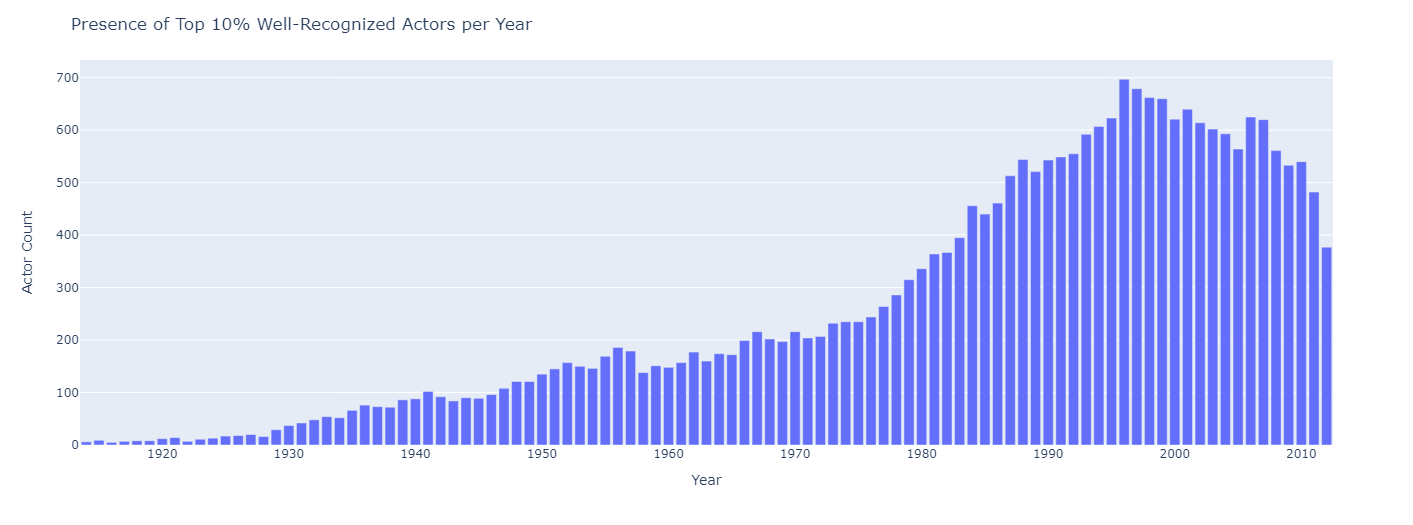

In [126]:
# Select the first 1200 actors
recognized_actors = general_recognition[:1200]

# Calculate fame threshold for each actor
fame_start_end_threshold = actor_year_df[['Actor Name','Recognition Coefficient']].groupby('Actor Name').max().reset_index()
fame_start_end_threshold['threshold'] = 0.3*fame_start_end_threshold['Recognition Coefficient']
fame_start_end_threshold.drop(columns='Recognition Coefficient', inplace=True)

# Keep Years that are above the threshold
actor_year_df2 = actor_year_df[actor_year_df['Actor Name'].isin(recognized_actors['Actor Name'])]
merged_df = pd.merge(actor_year_df2, fame_start_end_threshold, on='Actor Name', how='left')
result_df = merged_df[merged_df['Recognition Coefficient'] > merged_df['threshold']]

result_df2 = result_df.groupby('Year').count().reset_index()[['Year','Actor Name']]

# Plot using Plotly Express
fig = px.bar(result_df2, x='Year', y='Actor Name', labels={'Actor Name': 'Count'})
fig.update_layout(title='Presence of Top 10% Well-Recognized Actors per Year', xaxis_title='Year', yaxis_title='Actor Count')

# Save and show the figure
fig.write_html("htmls/well_recognized_actors_plot.html")
fig.show()

The above graphs showcases for every year how many of those 180 most recognized actors across all times were considered recognized, meaning with a recognition coefficient above the set threshsold.  Notably, a substantial portion of well-recognized actors emerges in years post-1980.

This raises the question: Are more actors gaining recognition after 1980? The data suggests an affirmative trend. For the subsequent phase (P3), pertinent inquiries could explore the factors contributing to this phenomenon. Is it linked to actors delivering enhanced performances leading to higher-rated movies? Could the surge be associated with contemporary actors participating in higher box office revenue-generating films? Is the increase due to actors being involved in more movies nowadays? Additionally, consideration should be given to potential confounders influencing this relationship and their impact.

---

## Part 2: Actor Recognition Longevity

In this section, the idea is to examine the span of the actors' Recognition through time. In other words, we are trying to find the year in which he started to be well-recognized and the year this recognition "ended". The criteria for determining these periods involve selecting the range of years in which the Actor Yearly Recognition Coefficient surpasses a defined threshold. This threshold is set at 50% of the actor's highest recognition coefficient score, providing a concise measure of the actor's sustained impact over time.

In [34]:
# Relative threshold for every actor, threshold being 30% of the Actor's Maximum Recognition

# Calculate fame threshold for each actor, threshold 50% of the maximum Recognition of this actor
fame_start_end_threshold = actor_year_df.groupby('Actor Name')['Recognition Coefficient'].max().reset_index()[['Actor Name','Recognition Coefficient']]
fame_start_end_threshold['threshold'] = 0.5*fame_start_end_threshold['Recognition Coefficient']
fame_start_end_threshold.drop(columns='Recognition Coefficient', inplace=True)


# Keep Recognition Values that are above the threshold
merged_df = pd.merge(actor_year_df, fame_start_end_threshold, on='Actor Name', how='left')
result_df = merged_df[merged_df['Recognition Coefficient'] > merged_df['threshold']]

# Find the minimum (first) and maximum (last) Year corresponding to these values
grouped = result_df.groupby('Actor Name').agg({'Year': ['min', 'max']})
grouped = grouped.reset_index()
grouped.columns = ['Actor Name', 'First Year', 'Last Year']  # Rename the columns
result_df = grouped.copy()  # Create a copy of grouped DataFrame

# Calculate the Range (last year - first year)
result_df['Range'] = result_df['Last Year'] - result_df['First Year']
result_df = result_df.sort_values(by='First Year')

result_df.head(1)

,Actor Name,First Year,Last Year,Range
5545,Frank Moore,1914,2011,97


In [35]:
# Group ranges for each first year by taking the mean and standard deviation of the range
filtered_actor_year_df = result_df.sort_values(by='First Year')
grouped_years = filtered_actor_year_df.groupby('First Year')['Range'].agg(['mean', 'std']).reset_index()

grouped_years.head(1)

,First Year,mean,std
0,1914,23.235294,25.542983


### Visualizing Average Span of Recognition through the years

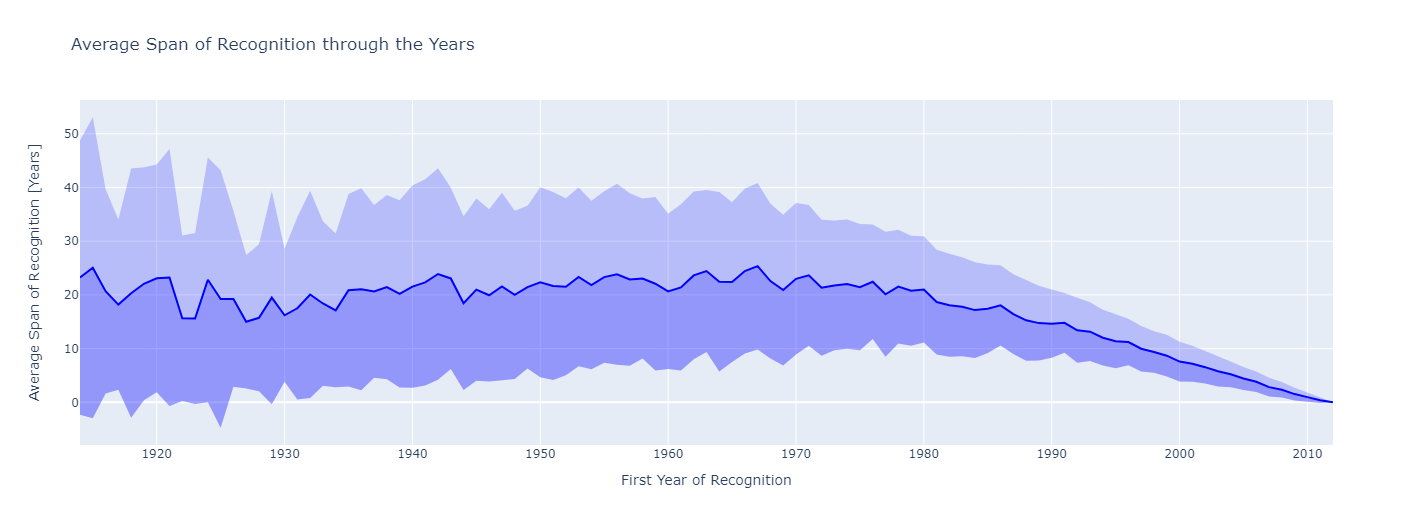

In [127]:
# Create figure
fig = go.Figure()

# Plot Mean and Standard Deviation
fig.add_trace(go.Scatter(
    x=grouped_years['First Year'],
    y=grouped_years['mean'],
    mode='lines',
    name='Average Span <br> of Recognition',
    line=dict(color='blue'),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=grouped_years['First Year'],
    y=grouped_years['mean'] - grouped_years['std'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0, 0, 255, 0.2)',  # Adjust transparency here
    line=dict(color='rgba(255, 255, 255, 0)'),  # Set line color to transparent
    showlegend=False  # Exclude from legend
))

fig.add_trace(go.Scatter(
    x=grouped_years['First Year'],
    y=grouped_years['mean'] + grouped_years['std'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0, 0, 255, 0.2)',  # Adjust transparency here
    line=dict(color='rgba(255, 255, 255, 0)'),  # Set line color to transparent
    showlegend=False  # Exclude from legend
))

# Update layout
fig.update_layout(
    title='Average Span of Recognition through the Years',
    xaxis=dict(title='First Year of Recognition'),
    yaxis=dict(title='Average Span of Recognition [Years]'),
    showlegend=False
    )

# Save and show the figure
fig.write_html('htmls/average_span_recognition_plot.html')
fig.show()

We observe that actors starting to be well-recognized after 1970 have decreasingly small spans of recognition. This is due to the fact the data we have ends in 2012, this means that these actors are probably still acting after 2012 but we don't have the corresponding data. Therefore the Last Year of recognition of these actors is considered to be around 2012 as we can see in the following histogram

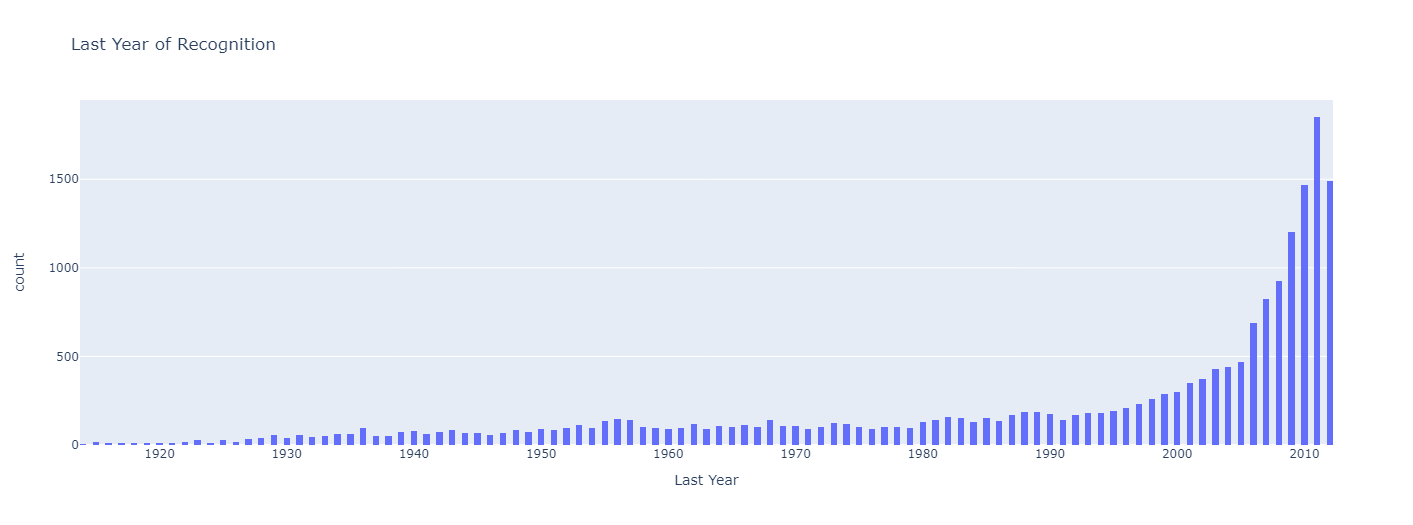

In [128]:
# Create histogram using Plotly Express
fig = px.histogram(
    result_df,
    x='Last Year',
    nbins=200,
    title='Last Year of Recognition',
    labels={'Last Year': 'Last Year', 'count': 'Count'})
# Update layout
fig.update_layout(showlegend=False)  # No legend for a histogram

# Save and show the figure
fig.write_html('htmls/last_year_recognition_histogram.html')
fig.show()

In order to evaluate the correlation between the average recognition span and first year of recognition, we use only the data before 1970, since the decrease of recognition span after 1970 is not reflective of the reality.

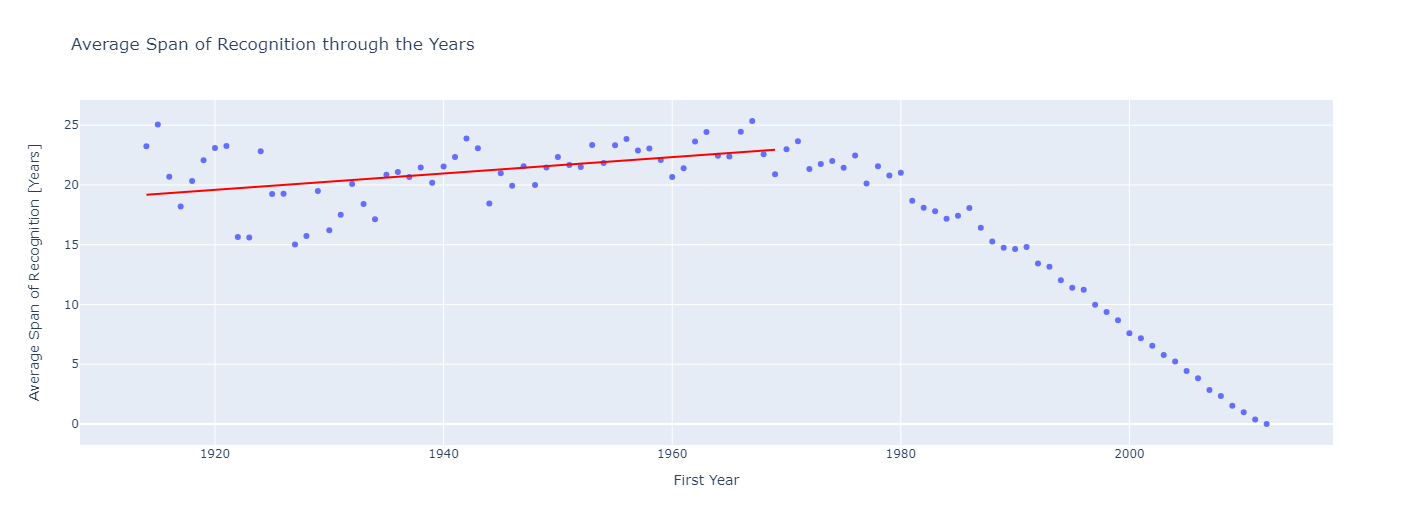

In [129]:
# Filter data before and after 1970
before_1970 = grouped_years[grouped_years['First Year'] < 1970]
after_1970 = grouped_years[grouped_years['First Year'] >= 1970]

# Calculate the standard deviation for before 1970
before_1970_std = before_1970['std']

# Filter data before and after 1970
before_1970 = grouped_years[grouped_years['First Year'] < 1970]
after_1970 = grouped_years[grouped_years['First Year'] >= 1970]

# Plotting
fig = px.scatter(before_1970, x='First Year', y='mean', labels={'mean': 'Average Span of Recognition'}, title='Average Span of Recognition through the Years')

# Add scatter points for after 1970
fig.add_trace(px.scatter(after_1970, x='First Year', y='mean').data[0])

# Update layout
fig.update_layout(xaxis_title='First Year', yaxis_title='Average Span of Recognition [Years]', showlegend=False)

# Add OLS before 1970
X = sm.add_constant(before_1970['First Year'])
model = sm.OLS(before_1970['mean'], X).fit()
fig.add_trace(go.Scatter(x=before_1970['First Year'], y=model.fittedvalues, mode='lines', line=dict(color='red'), name='Trendline'))

# Ssave and show the plot
fig.write_html('htmls/fitted_average_span_recognition_plot.html')
fig.show()

In [41]:
# Calculate Pearson Coefficient for before 1970
print(stats.pearsonr(before_1970['First Year'],before_1970['mean']))

PearsonRResult(statistic=0.44801970611996533, pvalue=0.0005351332288243282)


Based on the above graph and the Pearson coefficient we get (p-value<0.05), we observe a trend of increase in the average span of recognition for actors (before 1970). This result suggests that with time actors tend to have longer periods of recognition.

### Recognition coefficient of specific actors

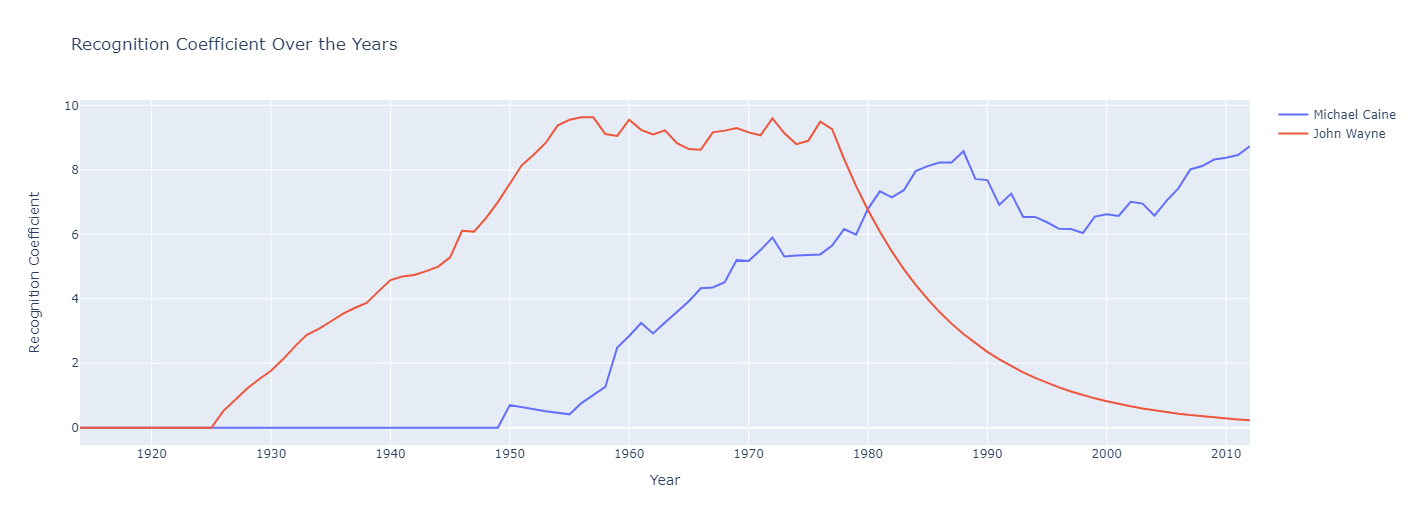

In [130]:
actor_names = ['Michael Caine', 'John Wayne']

# Create figure
fig = go.Figure()

# Plot the Recognition coefficient of specific actors
for actor_name in actor_names:
    particular_actor_df = actor_year_df[actor_year_df['Actor Name'] == actor_name]
    fig.add_trace(go.Scatter(x=particular_actor_df['Year'], y=particular_actor_df['Coefficient with Past'],
                             mode='lines', name=f'{actor_name}'))

fig.update_layout(title_text='Recognition Coefficient Over the Years',
                  xaxis_title='Year',
                  yaxis_title='Recognition Coefficient')

# Save and show the plot
fig.write_html('htmls/specific_actors.html')
fig.show()

From the graphs above, we can see how the Recognition of different actors varies with time:
- Michael Caine: We can see that Michael Caine has a very long span of recognition, starting to be well-recognized around 1960 until after 2012. It is also interesting to notice that for the period 1990-2000, he acted in less-succesful movies, but then he had his recognition increase again.
- John Wayne: The second plot with John Wayne is also very interesting since it allows to visualize the Recognition of an actor that stopped to be well-recognized. We can see how his recognition coefficient decreases with time abruptly after 1979, which is in fact the date of his death

---

## Part 3: Composition of actors in terms of gender over time

### Comparing the proportion of males to females in the data

In [43]:
# Grouping by the sex to see the yearly proportion of each of them.
characters_female = actor_movie_year.groupby(['Year']).apply(lambda x: len(x[x['Actor gender'] == 'F']))
characters_male = actor_movie_year.groupby(['Year']).apply(lambda x: len(x[x['Actor gender'] == 'M']))

# Calculate the percentage of female characters and male characters for each year
characters_female_perc = (characters_female / (characters_female + characters_male)) * 100.0
characters_male_perc = (characters_male / (characters_female + characters_male)) * 100.0

We plot the proportion of female and male actors over time.

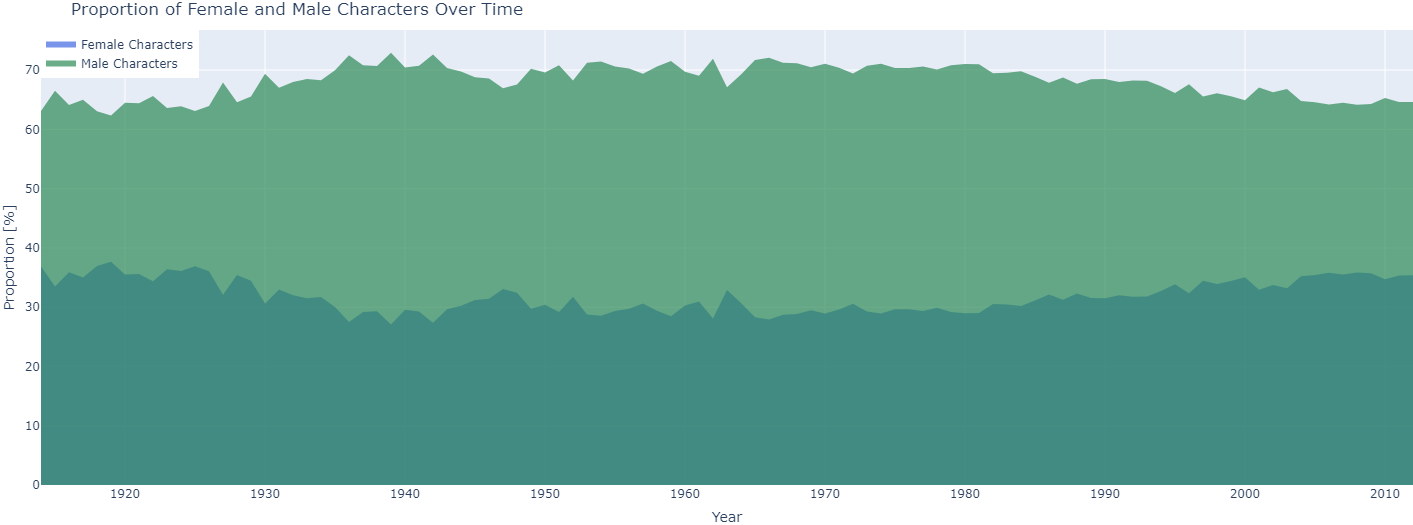

In [131]:
# Prepare data for plotting
years = characters_male_perc.index
female_perc = characters_female_perc.values
male_perc = characters_male_perc.values

# Create traces for stacked area chart
trace_female = go.Scatter(x=years, y=female_perc, fill='tozeroy', mode='none', name='Female Characters', fillcolor='rgba(65, 105, 225, 0.7)')
trace_male = go.Scatter(x=years, y=male_perc, fill='tozeroy', mode='none', name='Male Characters', fillcolor='rgba(46, 139, 87, 0.7)')

# Layout settings
layout = go.Layout(
    title='Proportion of Female and Male Characters Over Time',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Proportion [%]'),
    showlegend=True,
    legend=dict(x=0, y=1.0),
    margin=dict(l=0, r=0, t=30, b=0)
)

# Create figure
fig = go.Figure(data=[trace_female, trace_male], layout=layout)
fig.write_html('htmls/male_female_proportion.html')

# Display the plot
fig.show()

### Analyzing female film representation with respect to the feminist movement

The second wave feminist movement, prominent in the 1960s and 1970s, advocated for gender equality and reproductive rights. It gained momentum in the early 1960s, notably sparked by the publication of Betty Friedan's "The Feminine Mystique" in 1963, while its influence gradually waned by the early 1980s. It's intriguing to observe the evolution of female representation during and after this period as it can provide insights into societal shifts and the progress made toward gender parity in cinema.

The data is therefore divided into three parts that are interesting to analyze:
- Before the feminist movement: from 1914 to 1963.
- During the feminist movement: from 1963 to 1980.
- After the feminist movement: from 1980 to 2012.

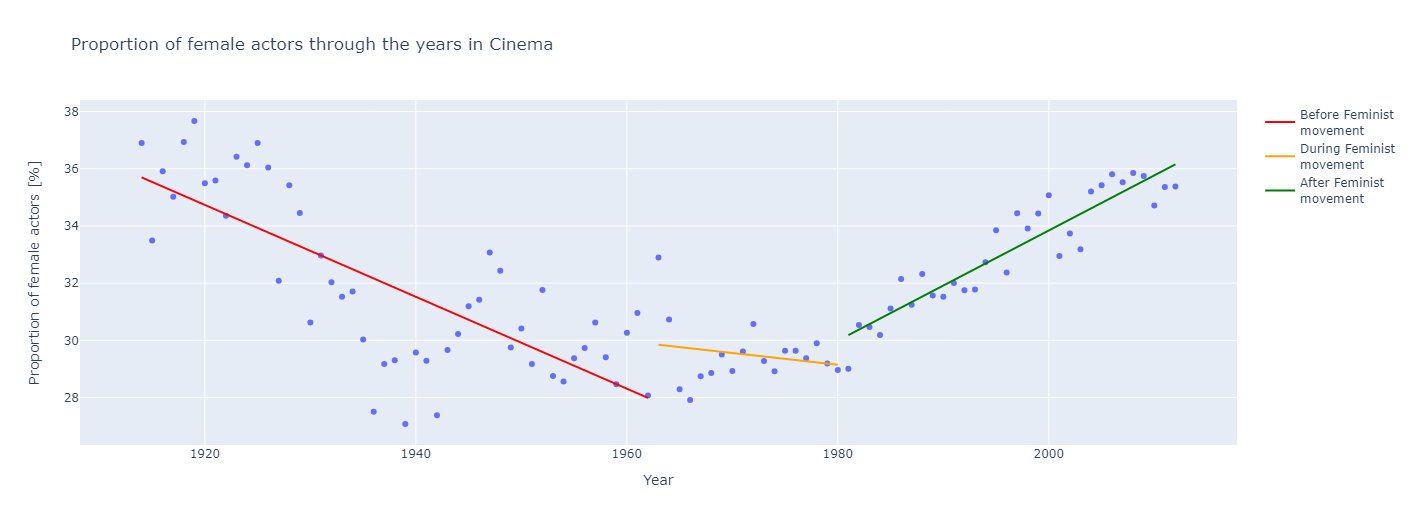

In [132]:
characters_female = pd.DataFrame(female_perc)
characters_female = characters_female.reset_index(drop=True)
characters_female.index += 1914
characters_female.reset_index(inplace=True)
characters_female.columns=['Year','Proportion']

fem_before_1963 = characters_female[characters_female['Year']<1963]
fem_between = characters_female[(characters_female['Year']>=1963)&(characters_female['Year']<=1980)]
fem_after_1980 = characters_female[characters_female['Year']>1980]

# Create a scatter plot for the entire dataset
fig = px.scatter(characters_female, x='Year', y='Proportion', labels={'Proportion': 'Proportion of female actors [%]'}, title='Proportion of female actors through the years in Cinema')

# Define function to plot regression line and return p-value
def plot_regression_and_pvalue(df, color, name):
    X = sm.add_constant(df['Year'])
    model = sm.OLS(df['Proportion'], X).fit()
    p_value = model.pvalues['Year']

    fig.add_trace(go.Scatter(x=df['Year'], y=model.fittedvalues, mode='lines', line=dict(color=color), name=f'{name}'))

# Plot regression lines for each period
plot_regression_and_pvalue(fem_before_1963, 'red', 'Before Feminist<br>movement')
plot_regression_and_pvalue(fem_between, 'orange', 'During Feminist<br>movement')
plot_regression_and_pvalue(fem_after_1980, 'green', 'After Feminist<br>movement')

# Update layout
fig.update_layout(xaxis_title='Year', yaxis_title='Proportion of female actors [%]')

# Save and show plot
fig.write_html('htmls/female_actors.html')
fig.show()

In [55]:
p_value = chow_test.p_value(fem_between['Year'], fem_between['Proportion'],fem_after_1980['Year'], fem_after_1980['Proportion'])

print("P-value:", p_value)

# Check if the difference is significant at a certain significance level (e.g., 0.05)
if p_value < 0.05:
    print("The difference is significant. Reject the null hypothesis.")
else:
    print("The difference is not significant. Fail to reject the null hypothesis.")

P-value: 9.078494351703452e-10
The difference is significant. Reject the null hypothesis.


We observe a decrease in female representation between 1914 and 1963 and an increase in female representation between 1980 and 2012. There appears to be a correlation between the dates of the feminist movement and the observed increase. However, definitive conclusions cannot be drawn until further analysis is conducted.

### Analyzing female film representation among the 10% most recognized actors

In [Part 1](##-Part-1:-Actors-Recognition), we designed a metric called the recognition coefficient that is meant to measure the recognition of a given actor on a given year. We will use this metric to select the 10% most recognized actors to study analyse female representation among this population.

In [47]:
# Let us take the 10% most well-recognized actors
top_10_perc = int(len(general_recognition)*0.1)
general_recognition_top = general_recognition[:top_10_perc]

characters_recognition_unique_top = actor_movie_year[actor_movie_year['Actor Name'].isin(general_recognition_top['Actor Name'])]

# Compute the yearly proportion of male and female as before for the top 1000 actors/actresses
characters_female_top = characters_recognition_unique_top.groupby(['Year']).apply(lambda x: len(x[x['Actor gender'] == 'F']))
characters_male_top = characters_recognition_unique_top.groupby(['Year']).apply(lambda x: len(x[x['Actor gender'] == 'M']))
characters_female_perc_top = (characters_female_top / (characters_female_top + characters_male_top)) * 100.0
characters_male_perc_top = (characters_male_top / (characters_female_top + characters_male_top)) * 100.0

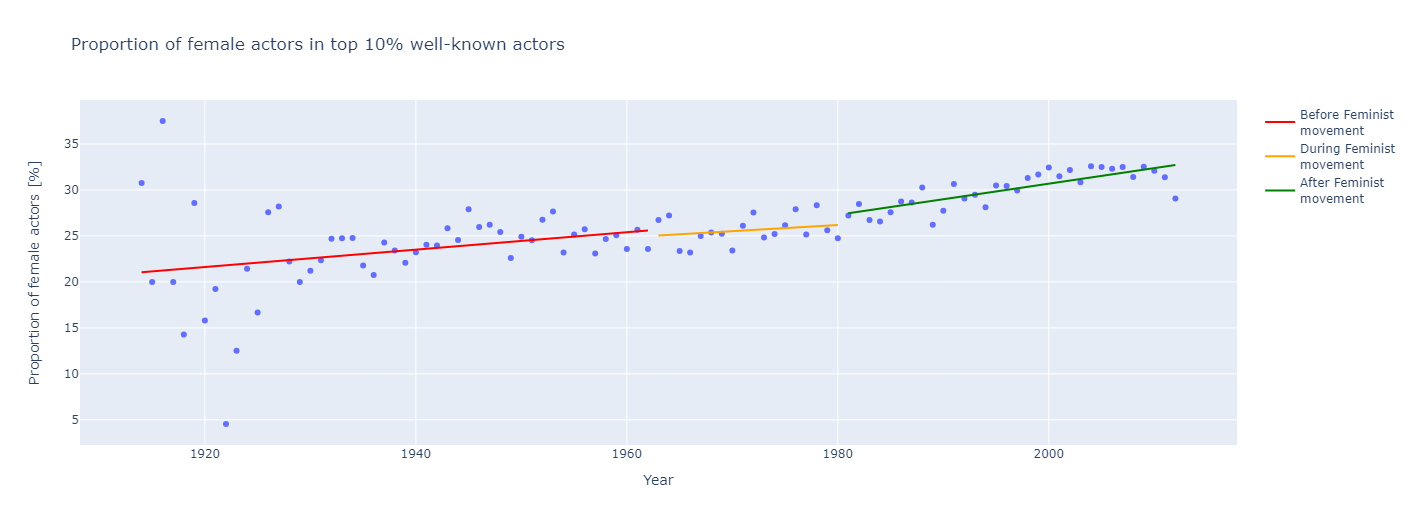

In [133]:
characters_female_perc_top_df = pd.DataFrame(characters_female_perc_top).reset_index()
characters_female_perc_top_df.columns = ['Year','Proportion']

fem_top_before_1963 = characters_female_perc_top_df[characters_female_perc_top_df['Year'] < 1963]
fem_top_between = characters_female_perc_top_df[(characters_female_perc_top_df['Year'] >= 1963) & (characters_female_perc_top_df['Year'] <= 1980)]
fem_top_after_1980 = characters_female_perc_top_df[characters_female_perc_top_df['Year'] > 1980]

# Create a scatter plot for the entire dataset
fig = px.scatter(characters_female_perc_top_df, x='Year', y='Proportion', labels={'Proportion': 'Proportion of female actors [%]'}, title='Proportion of female actors in top 10% well-known actors')

# Define function to plot regression line and return p-value
def plot_regression_and_pvalue(df, color, name):
    X = sm.add_constant(df['Year'])
    model = sm.OLS(df['Proportion'], X).fit()
    p_value = model.pvalues['Year']

    fig.add_trace(go.Scatter(x=df['Year'], y=model.fittedvalues, mode='lines', line=dict(color=color), name=f'{name}'))

# Plot regression lines for each period
plot_regression_and_pvalue(fem_top_before_1963, 'red', 'Before Feminist<br>movement')
plot_regression_and_pvalue(fem_top_between, 'orange', 'During Feminist<br>movement')
plot_regression_and_pvalue(fem_top_after_1980, 'green', 'After Feminist<br>movement')

# Update layout
fig.update_layout(xaxis_title='Year', yaxis_title='Proportion of female actors [%]')

# Save and show plot
fig.write_html('htmls/female_actors_10perc.html')
fig.show()

In [56]:
p_value = chow_test.p_value(fem_top_between['Year'],fem_top_between['Proportion'],fem_top_after_1980['Year'],fem_top_after_1980['Proportion'])

# # Print results
print("P-value:", p_value)

# Check if the difference is significant at a certain significance level (e.g., 0.05)
if p_value < 0.05:
    print("The difference is significant. Reject the null hypothesis.")
else:
    print("The difference is not significant. Fail to reject the null hypothesis.")

P-value: 2.21775535308097e-05
The difference is significant. Reject the null hypothesis.


### Analyzing the distribution of the recognition coefficient for male and female actors

In [57]:
# Getting recogniton coeffecient for male and female
recognition_male = general_recognition[general_recognition['Actor gender'] == 'M']
recognition_female = general_recognition[general_recognition['Actor gender'] == 'F']

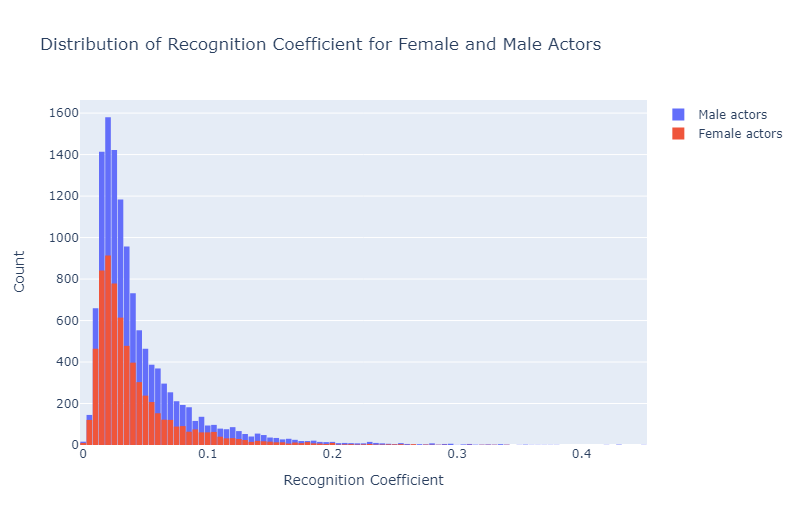

In [134]:
# Create histograms for male and female actors
hist_male = go.Histogram(x=recognition_male['Recognition Coefficient'], nbinsx=100, name='Male actors')
hist_female = go.Histogram(x=recognition_female['Recognition Coefficient'], nbinsx=100, name='Female actors')

# Layout settings
layout = go.Layout(
    title='Distribution of Recognition Coefficient for Female and Male Actors',
    xaxis=dict(title='Recognition Coefficient'),
    yaxis=dict(title='Count'),
    barmode='overlay',  # Overlay histograms for better comparison
    bargap=0.1  # Gap between bars
)

# Create figure
fig = go.Figure(data=[hist_male, hist_female], layout=layout)

# Update layout to add legend
fig.update_layout(
    showlegend=True
)

fig.update_layout(width=800)
fig.write_html('htmls/male_female_recognition.html')

# Display the plot
fig.show()

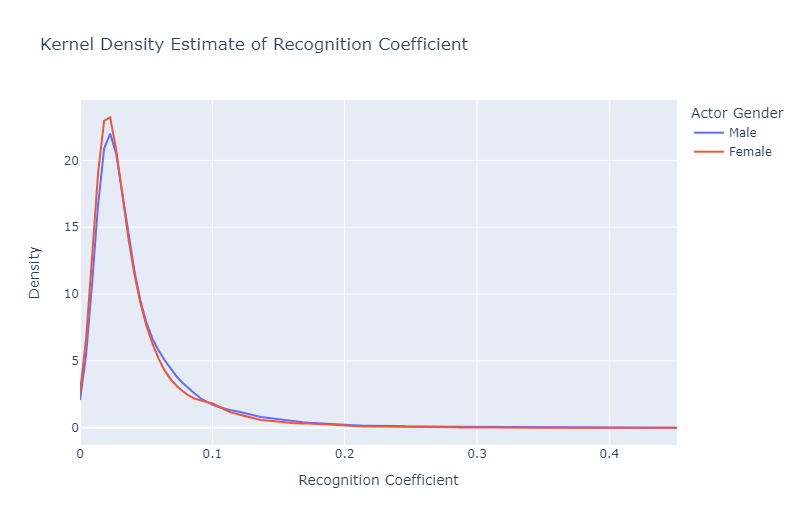

In [135]:
# Calculate kernel density estimate for male and female actors
density_male = stats.gaussian_kde(recognition_male['Recognition Coefficient'])
density_female = stats.gaussian_kde(recognition_female['Recognition Coefficient'])

# Generate x values for density plot
x_values = np.linspace(min(recognition_male['Recognition Coefficient'].min(), recognition_female['Recognition Coefficient'].min()),
                       max(recognition_male['Recognition Coefficient'].max(), recognition_female['Recognition Coefficient'].max()), 100)

# Calculate densities for male and female actors
density_male_values = density_male(x_values)
density_female_values = density_female(x_values)

df_male = pd.DataFrame({'Recognition Coefficient': x_values, 'Density': density_male_values, 'Actor Gender': 'Male'})
df_female = pd.DataFrame({'Recognition Coefficient': x_values, 'Density': density_female_values, 'Actor Gender': 'Female'})

# Combine male and female dataframes
df_combined = pd.concat([df_male, df_female], ignore_index=True)

# Plot KDE for both male and female actors using Plotly Express
fig = px.line(df_combined, x='Recognition Coefficient', y='Density', color='Actor Gender',
              line_shape='linear', title='Kernel Density Estimate of Recognition Coefficient',
              labels={'Density': 'Density', 'Recognition Coefficient': 'Recognition Coefficient'})

# Add legend
fig.update_layout(legend=dict(title='Actor Gender'))
fig.update_layout(width=800)  # You can adjust the width as needed

# Show plot
fig.show()
fig.write_html('htmls/recognition_densities.html')

In [136]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(df_male['Density'], df_female['Density'])

print('The p-value is: {}'.format(p_value))

The p-value is: 0.024055802841094577


Notes about the histograms :
* Both male and female actors generally have lower recognition coefficients, but males show a wider range of values.
* The distributions are right-skewed, indicating more actors are at the lower recognition end, with few exceptionally high values.
* Male actors have a longer tail in their distribution, suggesting a higher occurrence of very famous actors compared to females.

Since the number of male actors is much larger than the number of female actors and since the distributions are heavy tailed we choose to plot the density of the distributions in order to check for the differences between them.

We perform the Kolmogorov-Smirnov test to compare whether the two distributions are identical or not.

Summary of the statistical test:
* H0 : The two distributions are the same
* $\alpha = 0.05$
* We reject the null namely that both distributions are the same. This would mean that the distributions of recognition coefficients for male and female actors are statistically different. However, as seen in the lectures,  rejecting the null hypothesis doesn't necessarily prove the alternative hypothesis.

Indeed, it can be seen from the plots that the slope of the density is steeper for the distribution of female actors which may suggest that highly recognized actresses are rarer upon female actors than highly recognized actors among male actors.

### Gender and Actor first appearence

In [60]:
# Let us compute the number of NaN values in the 'actor_age_release' which corresponds to the age of the actor at the time of the movie release
print('Number of NaN values in the actor_age_release column is : {}'.format(actor_movie_year['Actor age at movie release'].isna().sum()))

Number of NaN values in the actor_age_release column is : 32169


Another intersting factor that we can analyze with regards to the differences between male and female actors is the age at which each gender starts acting.

In [61]:
# We have a dataset taken from IDMB which contains the birthYear of the actors
# In our dataset we have the movie release year, we can compute the age of the actor at the time of the movie release
# Start by merging the two datasets on the Actor Name
# First we change the column name in IMDB dataset to match the one in the characters dataset
imdb_actor_name.rename(columns = {'primaryName' : 'Actor Name'}, inplace = True)
# We remove the rows with missing birthYear
imdb_actor_name = imdb_actor_name[imdb_actor_name['birthYear'] != '\\N']

# We have some false values in the birthYear column, we need to remove them to ensure the correctness of the age
# We take years bewteen 1910 and 2013
imdb_actor_name = imdb_actor_name[(imdb_actor_name['birthYear'] > '1910') & (imdb_actor_name['birthYear'] < '2013')]

# Merging the two datasets on Actor Name
characters_recognition_unique_merged = pd.merge(actor_movie_year, imdb_actor_name[['Actor Name','birthYear']], on = 'Actor Name', how = 'left')

# Convert'birthYear' to numeric for proper calculations.
characters_recognition_unique_merged['birthYear'] = pd.to_numeric(characters_recognition_unique_merged['birthYear'], errors='coerce')

# Computing the age of the actor at the time of the movie release
characters_recognition_unique_merged['age_at_release'] = characters_recognition_unique_merged['Year'] - characters_recognition_unique_merged['birthYear']

characters_recognition_unique_merged['Actor age at movie release'] = characters_recognition_unique_merged['Actor age at movie release'].fillna(characters_recognition_unique_merged['age_at_release'])
characters_recognition_unique_merged.drop(['age_at_release'], axis=1,inplace=True)

# Now we check for NaN values in the 'age_at_release' column
print('Number of NaN values in the age_at_release column is : {}'.format(
    characters_recognition_unique_merged['Actor age at movie release'].isna().sum())
)

# Remove the rows with age_at_release that are negative or zero
characters_recognition_unique_merged = characters_recognition_unique_merged[
    characters_recognition_unique_merged['Actor age at movie release'] > 0
]

#Two dataframes : one for male and female
male_df = characters_recognition_unique_merged[characters_recognition_unique_merged['Actor gender'] == 'M']
female_df = characters_recognition_unique_merged[characters_recognition_unique_merged['Actor gender'] == 'F']

# Group by Actor Name and get the minimum age at release to get the age at release for the first movie for both

male_min= male_df[['Actor Name','Actor age at movie release']].groupby(['Actor Name']).min()
female_min = female_df[['Actor Name','Actor age at movie release']].groupby(['Actor Name']).min()

# Two dataframes : one for male and female
male_df = characters_recognition_unique_merged[characters_recognition_unique_merged['Actor gender'] == 'M']
female_df = characters_recognition_unique_merged[characters_recognition_unique_merged['Actor gender'] == 'F']


# Group by Actor Name and get the minimum age at release to get the age at release for the first movie for both
male_min= male_df[['Actor Name','Actor age at movie release']].groupby(['Actor Name']).min()
female_min = female_df[['Actor Name','Actor age at movie release']].groupby(['Actor Name']).min()

Number of NaN values in the age_at_release column is : 20724


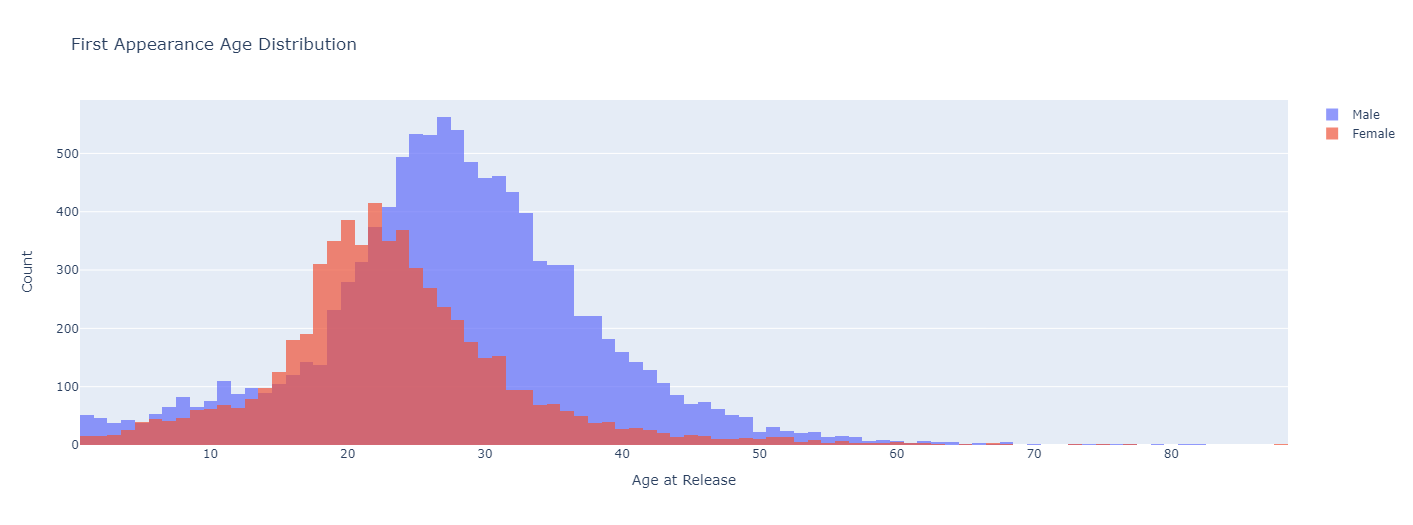

In [137]:
# Create a combined histogram for both male and female actors
hist_combined = go.Figure()

# Plot the histogram for male actors
hist_combined.add_trace(go.Histogram(x=male_min['Actor age at movie release'], nbinsx=100, name='Male', opacity=0.7))

# Plot the histogram for female actors
hist_combined.add_trace(go.Histogram(x=female_min['Actor age at movie release'], nbinsx=100, name='Female', opacity=0.7))

# Update layout
hist_combined.update_layout(title_text="First Appearance Age Distribution",
                            xaxis_title="Age at Release",
                            yaxis_title="Count",
                            showlegend=True,
                            barmode='overlay')  # 'overlay' mode for histograms to be overlaid

# Show and save the plot
hist_combined.show()
hist_combined.write_html('htmls/1st_appearance_hist.html')

Some observation on the 1st appearence age of actors:
* Male actors tend to have their first appearance at a wider age range, peaking between 25 and 35, while female actors peak earlier, between 20 and 30.
* Female actors show a steeper decline in first appearances after the age of 30, indicating a narrower age range for debut roles.
* The male age distribution has a longer tail into older ages, suggesting that males are more likely to start their acting careers later in life than females

In [ ]:
st.ttest_ind(female_min['Actor age at movie release'],male_min['Actor age at movie release'])

Ttest_indResult(statistic=-24.70751118065309, pvalue=2.813054702202364e-131)

Summary of the statistical test:
* H0 : There is no significant difference in the mean ages of actors at movie release between the female and male groups in the dataset.
* $\alpha = 0.05$
* Result: We reject the null hypothesis.

In [63]:
# Concatenate dataframes and add a 'Gender' column
female_min['Gender'] = 'F'
male_min['Gender'] = 'M'
combined_data = pd.concat([female_min, male_min])
combined_data.reset_index(inplace=True)

# Rename
combined_data.rename(columns={'Actor age at movie release': 'age'}, inplace=True)

# Correcting the formula with backticks for the column name with space
mod = smf.ols(formula='age ~ C(Gender)', data=combined_data)

# Fit the model
results = mod.fit()

# View the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     876.9
Date:                Thu, 21 Dec 2023   Prob (F-statistic):          7.36e-188
Time:                        14:07:33   Log-Likelihood:                -61402.
No. Observations:               16656   AIC:                         1.228e+05
Df Residuals:                   16654   BIC:                         1.228e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         23.3667      0.125    187.

We can see from these results that the intercept value of 23.5590 is the estimated average age for female actors and the coefficient (activated value when Male == True) show that, on average, male actors are estimated to be approximately 4.89 years older than female actors. The following plot showcaes these observations.

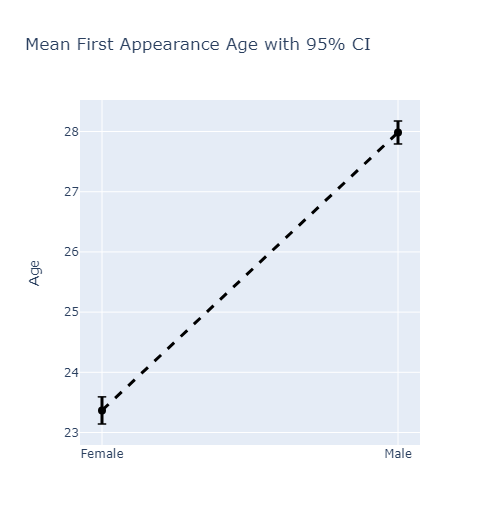

In [138]:
# Calculate mean and confidence interval for each group
mean_by_gender = combined_data.groupby('Gender')['age'].mean().to_dict()
std_by_gender = combined_data.groupby('Gender')['age'].std().to_dict()
count_by_gender = combined_data.groupby('Gender')['age'].count().to_dict()

# Create a Plotly figure with mean, confidence interval, and connecting line
fig = go.Figure()

# Add mean points and confidence interval
for gender in mean_by_gender.keys():
    mean_age = mean_by_gender[gender]
    std_age = std_by_gender[gender]
    count = count_by_gender[gender]

    margin_of_error = stats.t.ppf(0.975, df=count-1) * (std_age / (count ** 0.5))

    fig.add_trace(go.Scatter(x=[gender, gender], y=[mean_age - margin_of_error, mean_age + margin_of_error],
                             mode='lines',
                             name=f'95% CI {gender}',
                             line=dict(color='black', width=3),
                             showlegend=False))

    fig.add_trace(go.Scatter(x=[gender], y=[mean_age],
                             mode='markers',
                             name=f'Mean {gender}',
                             marker=dict(color='black', size=8),
                             showlegend=False))
    fig.add_trace(go.Scatter(x=[gender, gender], y=[mean_age + margin_of_error, mean_age + margin_of_error],
                             mode='markers',
                             name=f'Mean {gender}',
                             marker=dict(symbol='line-ew-open',color='black'),
                             showlegend=False))
    fig.add_trace(go.Scatter(x=[gender, gender], y=[mean_age - margin_of_error, mean_age - margin_of_error],
                             mode='markers',
                             name=f'Mean {gender}',
                             marker=dict(symbol='line-ew-open',color='black'),
                             showlegend=False))

# Add connecting line between means
fig.add_trace(go.Scatter(x=['F', 'M'], y=[mean_by_gender['F'], mean_by_gender['M']],
                         mode='lines',
                         name='Connecting Line',
                         line=dict(color='black', width=3, dash='dash'),
                             showlegend=False))

fig.update_layout(
    xaxis=dict(tickvals=['F', 'M'], ticktext=['Female', 'Male']),
    title='Mean First Appearance Age with 95% CI',
    yaxis_title='Age'
)
fig.update_layout(width=500)

# Save and show the plot
fig.write_html('htmls/1st_appearance_ci.html')
fig.show()

## Part 4: Composition of actors in terms of ethnicity over time

### Preprocessing

#### Get ethnicities mapping for the first time

After exploring the data, we discovered that the ethnicities are not explicitly given, they are given in the form of Freebase IDs. In order to have the ethnicities we need to find the mapping from the Freebase IDs to their ethnicities.  The Freebase API has been replaced by the Knowledge Graph API. This API allows us the get the names of the ethnicities from their ids. We can request the API by providing the id of an entity. The server responds with the data associated with the given id.

In [65]:
actor_movie_year.head(1)

,Actor Name,Year,Recognition Coefficient,Date,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release
70627,Jacques Jaccard,1914,NaN,1914-01-05,1886-09-11,M,None,NaN


In [66]:
DATA_FOLDER = './data/'

# Get ethnicities (to only excute once as the result is saved)
api_key = '<this-is-secret>' # Put your personal key here
url = 'https://kgsearch.googleapis.com/v1/entities:search'

ethnicity_map = {'': ''}
# Iterate over all referenced ethnicity ids
for eth_id in actor_movie_year['Actor ethnicity (Freebase ID)'].dropna().unique():
    ethnicity_map[eth_id] = ''

    # Send the request to get the item that matches the id 'eth_id'
    params = {'ids': eth_id, 'indent': True, 'key': api_key}
    response = requests.get(url, params=params)
    response = json.loads(response.text)

    # There should be only one result
    if len(response['itemListElement']) == 1:
        ethnicity_map[eth_id] = response['itemListElement'][0]['result']['name']

# Save the result so that we only have to run this once
with open(DATA_FOLDER+'ethnicity_mapping.json', mode='w') as f:
    json.dump(ethnicity_map, f)

Load ethnicities maps for the next times from the `DATA_FOlDER`, avoiding to scrap for each iteration.

In [67]:
DATA_FOLDER = './data/'
with open(DATA_FOLDER+'ethnicity_mapping.json', mode='r') as f:
    ethnicity_map = json.load(f)

#### Map the ethnicity IDs to their names in the dataframes

In [82]:
# Map ethnicity ID to name
actor_movie_year['Actor ethnicity (Freebase ID)'].fillna('', inplace=True)
actor_movie_year["Actor ethnicity"] = actor_movie_year["Actor ethnicity (Freebase ID)"].apply(lambda x: ethnicity_map[x])
# Drop ethnicity IDs
actor_ethnicity_year = actor_movie_year.drop("Actor ethnicity (Freebase ID)", axis=1)
actor_ethnicity_year.head(2)

,Actor Name,Year,Recognition Coefficient,Date,Actor date of birth,Actor gender,Actor age at movie release,Actor ethnicity
70627,Jacques Jaccard,1914,NaN,1914-01-05,1886-09-11,M,NaN,
149098,Roscoe Arbuckle,1914,0.384457,1914-01-17,1887-03-24,M,NaN,Scottish Americans


In [83]:
# Map ethnicity ID to name
general_recognition['Actor ethnicity (Freebase ID)'].fillna('', inplace=True)
general_recognition["Actor ethnicity"] = general_recognition["Actor ethnicity (Freebase ID)"].apply(lambda x: ethnicity_map[x])
# Drop ethnicity IDs
general_recog_ethnicity = general_recognition.drop("Actor ethnicity (Freebase ID)", axis=1)
general_recog_ethnicity.head(2)

,Actor Name,Recognition Coefficient,Actor date of birth,Actor gender,Actor ethnicity
0,Clint Eastwood,0.451164,1930-05-31,M,
1,John Wayne,0.431345,1907-05-26,M,Scotch-Irish Americans


#### Enrich dataframes with data from Wikipedia
Since the there's a considerable amount of missing ethnicities, we add some of them by extracting ethnicities data from Wikipedia

In [84]:
missing_data_before = general_recog_ethnicity[general_recog_ethnicity['Actor ethnicity'] == ''].shape[0]
print('Number of missing ethnicities before extracting data from Wikipedia: %d' % (missing_data_before))

Number of missing ethnicities before extracting data from Wikipedia: 15124


We scrap three pages from Wikipedia:
- [List of African-American actors](https://en.wikipedia.org/wiki/List_of_African-American_actors)
- [List of Hispanic and Latino American actors](https://en.wikipedia.org/wiki/List_of_Hispanic_and_Latino_American_actors)
- [List of Italian-American actors](https://en.wikipedia.org/wiki/List_of_Italian-American_actors)

For the three pages that we scrap, the actors names are listed in \<ul\> cells.

To retrieve them, one just have to provide the first and the last actor names of the list. The method scans the whole page and starts extracting the values of the \<li\< cells when detecting the first actor. The scan ends when the last actor is read.

In [73]:
# Method to extract lists of actor names
def wiki_actors_from_ethnicity(url, first_actor, last_actor, json_name):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    extract = False
    actors = []
    for ul in soup.find_all("ul"):
        for li in ul.find_all("li"):
            if li.a:
                # Start the scan when detecting the first actor
                if li.a.text == first_actor:
                    extract = True

                if extract:
                    actors.append(li.a.text)

                # End the scan when detecting the last actor
                if li.a.text == last_actor:
                    extract = False
                    break

    # Save the list
    with open(json_name, mode="w") as f:
        json.dump(actors, f)

In [71]:
# URLs to scrap
URLS = [
    "https://en.wikipedia.org/wiki/List_of_African-American_actors",
    "https://en.wikipedia.org/wiki/List_of_Hispanic_and_Latino_American_actors",
    "https://en.wikipedia.org/wiki/List_of_Italian-American_actors",
]

# First and last actors names in the lists
FIRST_ACTORS = [
    "Ira Aldridge",
    "Fernando Michelena",
    "Robert G. Vignola"
]

LAST_ACTORS = [
    "Saniyya Sidney",
    "Elena Tovar",
    "Francesca Capaldi"
]

JSON_NAMES = [
    DATA_FOLDER+"wiki_african_american_actors.json",
    DATA_FOLDER+"wiki_hispanic_latino_american_actors.json",
    DATA_FOLDER+"wiki_italian_american_actors.json"
]

# Corresponding ethnicity names
ETHNICITY_NAMES = [
    "African Americans",
    "Hispanic and Latino Americans",
    "Italian Americans"
]

In [74]:
# Extract actors names (to execute only once as the result is saved)
for url, first_actor, last_actor, json_name in zip(URLS, FIRST_ACTORS, LAST_ACTORS, JSON_NAMES):
    wiki_actors_from_ethnicity(url, first_actor, last_actor, json_name)

In [85]:
# Fill the ethnicities for the rows that have missing value
for json_name, ethnicity_name in zip(JSON_NAMES, ETHNICITY_NAMES):
    with open(json_name, mode="r") as f:
        ethnicity_actors = json.load(f)

    # Fill both dataframes
    mask = (actor_ethnicity_year['Actor ethnicity'] == '') & (actor_ethnicity_year['Actor Name'].isin(ethnicity_actors))
    actor_ethnicity_year.loc[mask, 'Actor ethnicity'] = ethnicity_name

    mask = (general_recog_ethnicity['Actor ethnicity'] == '') & (general_recog_ethnicity['Actor Name'].isin(ethnicity_actors))
    general_recog_ethnicity.loc[mask, 'Actor ethnicity'] = ethnicity_name

In [86]:
missing_data_after = general_recog_ethnicity[general_recog_ethnicity['Actor ethnicity'] == ''].shape[0]
print('Number of missing ethnicities after extracting data from Wikipedia: %d.' % (missing_data_after))
print('Hence, %d entries for ethnicity have been filled.' % (missing_data_before - missing_data_after))

Number of missing ethnicities after extracting data from Wikipedia: 14881.
Hence, 243 entries for ethnicity have been filled.


Assuming that the missing values are randomly distributed between the ethnicities, we can move on with our analysis assuming that the values we have are representative of each ethnicity.

In [87]:
general_recog_ethnicity

,Actor Name,Recognition Coefficient,Actor date of birth,Actor gender,Actor ethnicity
0,Clint Eastwood,0.451164,1930-05-31,M,
1,John Wayne,0.431345,1907-05-26,M,Scotch-Irish Americans
2,Michael Caine,0.427673,1933-03-14,M,
3,Robert De Niro,0.418744,1943-08-17,M,Italian Americans
4,Sylvester Stallone,0.381940,1946-07-06,M,Italian Americans
...,...,...,...,...,...
19218,Vichara Dany,0.000000,1948,F,
19219,Jimmy Zoppi,0.000000,1954-03-08,M,
19220,Zaki Rostom,0.000000,1903-03-05,M,
19221,Masashi Hirose,0.000000,1947-11-06,M,


In [88]:
# Map missing values to 'Unknown'
actor_ethnicity_year.loc[actor_ethnicity_year['Actor ethnicity'] == '', 'Actor ethnicity'] = 'Unknown'
general_recog_ethnicity.loc[general_recog_ethnicity['Actor ethnicity'] == '', 'Actor ethnicity'] = 'Unknown'
general_recog_ethnicity

,Actor Name,Recognition Coefficient,Actor date of birth,Actor gender,Actor ethnicity
0,Clint Eastwood,0.451164,1930-05-31,M,Unknown
1,John Wayne,0.431345,1907-05-26,M,Scotch-Irish Americans
2,Michael Caine,0.427673,1933-03-14,M,Unknown
3,Robert De Niro,0.418744,1943-08-17,M,Italian Americans
4,Sylvester Stallone,0.381940,1946-07-06,M,Italian Americans
...,...,...,...,...,...
19218,Vichara Dany,0.000000,1948,F,Unknown
19219,Jimmy Zoppi,0.000000,1954-03-08,M,Unknown
19220,Zaki Rostom,0.000000,1903-03-05,M,Unknown
19221,Masashi Hirose,0.000000,1947-11-06,M,Unknown


#### Reduce the ethnicities to 6 main ethnicities
Since the there's a large amount of different very specific ethnicities, we reduce these to seven main ones : African, Arabic, Asian, European, Hispanic, and Native.

In [ ]:
# Write ethnicities to file
with open(DATA_FOLDER+"all_ethnicities.txt", mode="w") as w:
    w.writelines("\n".join(actor_ethnicity_year['Actor ethnicity'].values.tolist()))

In [ ]:
# Categorize the ethnicities by hand (DO NOT RUN THIS CELL AGAIN)
africans, arabics, asians, europeans, hispanics, natives, others = set(), set(), set(), set(), set(), set(), set(), set()
with open(DATA_FOLDER+"all_ethnicities.txt", mode="r") as r:
    for line in r.readlines():
        name = line[:-1]
        print(name, flush=True)

        choice = input()
        if choice == "af":
            africans.add(name)
        elif choice == "ar":
            arabics.add(name)
        elif choice == "as":
            asians.add(name)
        elif choice == "eu":
            europeans.add(name)
        elif choice == "hi":
            hispanics.add(name)
        elif choice == "na":
            natives.add(name)
        else:
            others.add(name)

In [ ]:
# Save the results
to_save = [("african", africans), ("arabic", arabics), ("asian", asians), ("european", europeans),
           ("hispanic", hispanics), ("native", natives)]

for name, sett in to_save:
    with open(DATA_FOLDER+f"{name}_people.txt", mode="w") as w:
        for el in sett:
            w.write(el+"\n")

In [80]:
# Create mapping to reduce number of ethnicities
reduce_eth_map = {}
for eth in ["african", "arabic", "asian", "european", "hispanic", "native"]:
    with open(DATA_FOLDER+f"{eth}_people.txt", mode="r") as r:
        for line in r.readlines():
            if line == "":
                break
            name = line[:-1]
            reduce_eth_map[name] = eth

# Add entry for missing values
reduce_eth_map['Unknown'] = 'missing'

In [89]:
# Reduce the ethnicities
actor_ethnicity_year["Actor ethnicity (reduced)"] = actor_ethnicity_year["Actor ethnicity"].apply(lambda x: reduce_eth_map[x])
actor_ethnicity_year.head(2)

,Actor Name,Year,Recognition Coefficient,Date,Actor date of birth,Actor gender,Actor age at movie release,Actor ethnicity,Actor ethnicity (reduced)
70627,Jacques Jaccard,1914,NaN,1914-01-05,1886-09-11,M,NaN,Unknown,missing
149098,Roscoe Arbuckle,1914,0.384457,1914-01-17,1887-03-24,M,NaN,Scottish Americans,european


In [90]:
# Map the ethnicities
general_recog_ethnicity["Actor ethnicity (reduced)"] = general_recog_ethnicity["Actor ethnicity"].apply(lambda x: reduce_eth_map[x])
general_recog_ethnicity.head(2)

,Actor Name,Recognition Coefficient,Actor date of birth,Actor gender,Actor ethnicity,Actor ethnicity (reduced)
0,Clint Eastwood,0.451164,1930-05-31,M,Unknown,missing
1,John Wayne,0.431345,1907-05-26,M,Scotch-Irish Americans,european


### Actors Ethnicities

#### Number of actors for a specific ethnicity per year
In this part we examine the number of actors for a specific ethnicity per year

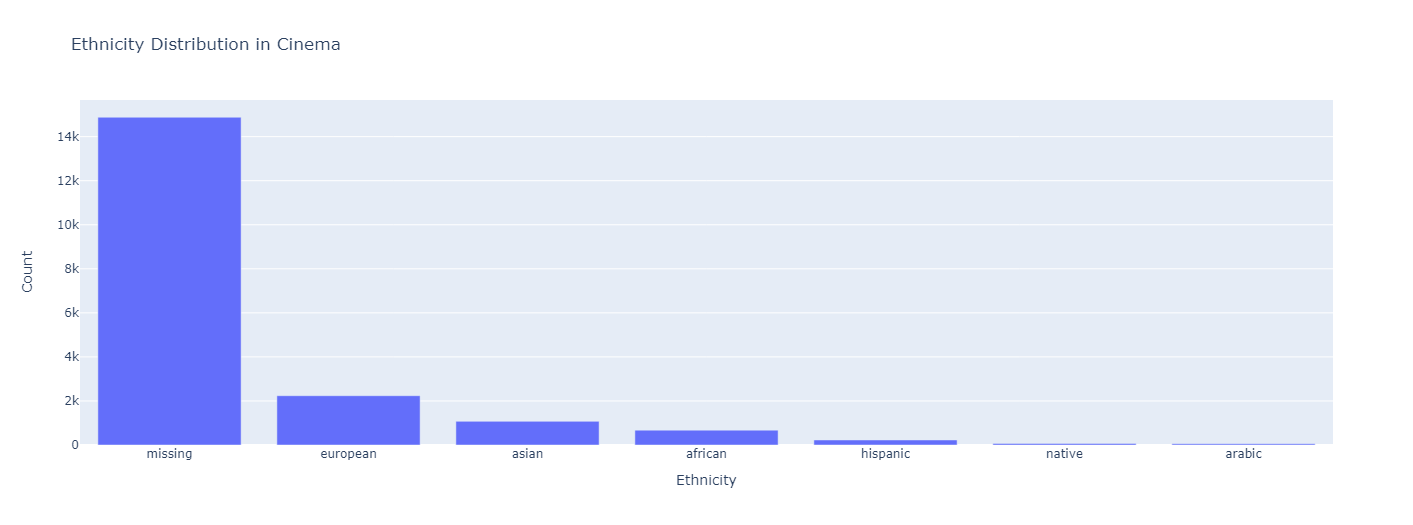

In [139]:
# Group by ethnicity and count occurrences
ethnicity_counts = general_recog_ethnicity['Actor ethnicity (reduced)'].value_counts().reset_index()
ethnicity_counts.columns = ['Ethnicity', 'Count']

# Create a bar plot using Plotly
fig = px.bar(ethnicity_counts, x='Ethnicity', y='Count', title='Ethnicity Distribution in Cinema')

# Save the figure
fig.write_html('htmls/Ethnicity_Distribution.html')
fig.show()

Let us see how the number of actors of the top 4 ethnicities vary with time.

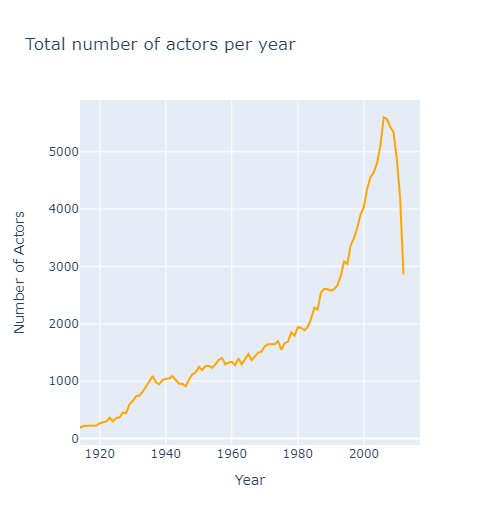

In [140]:
# Group the data by year and calculate the total number of actors per year
total_actors_per_year = actor_ethnicity_year.groupby('Year').size().reset_index(name='Number of actors')

# Create a Plotly figure for the total number of actors per year
fig_total_actors = px.line(total_actors_per_year, x='Year', y='Number of actors',
                           title='Total number of actors per year',
                           labels={'Number of actors': 'Number of Actors', 'Year': 'Year'},
                           range_x=[1914, 2017])

# Update the line color in the layout
fig_total_actors.update_traces(line=dict(color='orange'))

fig_total_actors.update_layout(width=500)

# Save the figure
fig_total_actors.write_html('htmls/total_actors_ethnicity.html')
fig_total_actors.show()

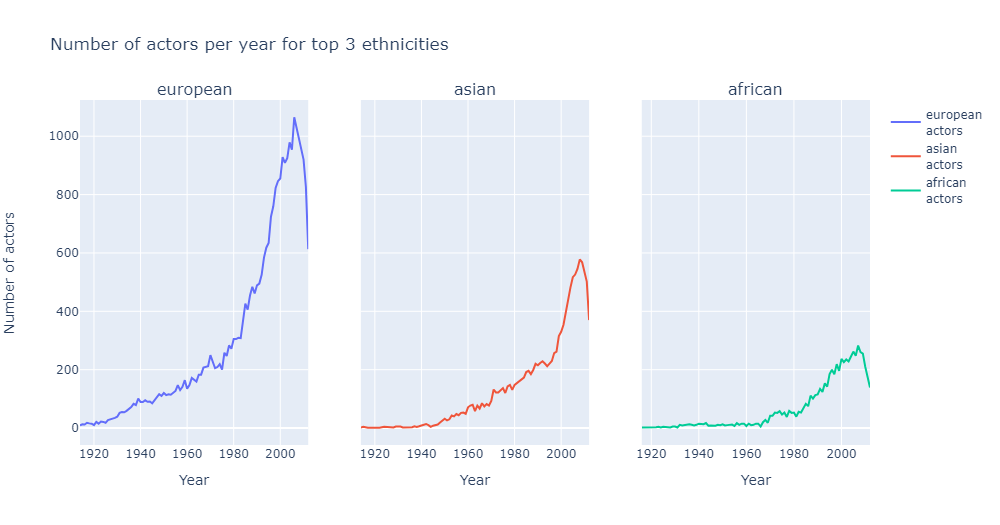

In [141]:
# Extract the top 4 ethnicities based on the counts
top_4_ethnicities = ethnicity_counts[1:4]

# Create subplots for each of the top 4 ethnicities
fig = make_subplots(rows=1, cols=len(top_4_ethnicities), subplot_titles=top_4_ethnicities['Ethnicity'].values, shared_yaxes=True)

# Iterate through the top 4 ethnicities and plot the number of actors per year for each ethnicity
for idx, eth in enumerate(top_4_ethnicities['Ethnicity'].values):
    # Filter data for the current ethnicity
    ethnicity_actors = actor_ethnicity_year[actor_ethnicity_year['Actor ethnicity (reduced)'] == eth]

    # Group the filtered data by year
    nb_ethnicity_actors_per_year = ethnicity_actors.groupby(['Year']).size().reset_index(name='Number of actors')

    # Add trace for the current ethnicity
    fig.add_trace(go.Scatter(x=nb_ethnicity_actors_per_year['Year'], y=nb_ethnicity_actors_per_year['Number of actors'],
                             mode='lines', name=f"{eth}<br>actors"),
                  row=1, col=idx + 1)

    # Set the title and labels for each subplot
    fig.update_xaxes(title_text="Year", row=1, col=idx + 1)

fig.update_yaxes(title_text="Number of actors", row=1, col=idx + 1)

# Update the layout
fig.update_layout(title_text="Number of actors per year for top 3 ethnicities", showlegend=True)
fig.update_layout(width=1000)

# Save the figure
fig.write_html('htmls/actors_ethnicity.html')
fig.show()

Since we are interested in the representation of African actors in Cinema, let us take a look at the third plot.
Similarly to the other plots, we can see that the number of actors of this ethnicity increases with time. However, for African actors, we observe a sudden increase in their number around 1970. This sudden increase is not perceived in the other plots. This sudden increase could be attributed to the Civil Right Movement which started in 1954 and ended in 1968.

In the meantime, we can see that that the total number of actors (regardless of the ethnicity) increases with time. Therefore, the sudden increase in African actors could be a result of this increase. In order to remove the bias of increasing number of actors, we can examine the **proportion** of actors of each ethnicity instead of their **count**. Examining the **proportion** of African in Cinema through the years, could help clarify the impact of the Civil rights movement on their representation.

#### Proportion of actors for a specific ethnicity per year

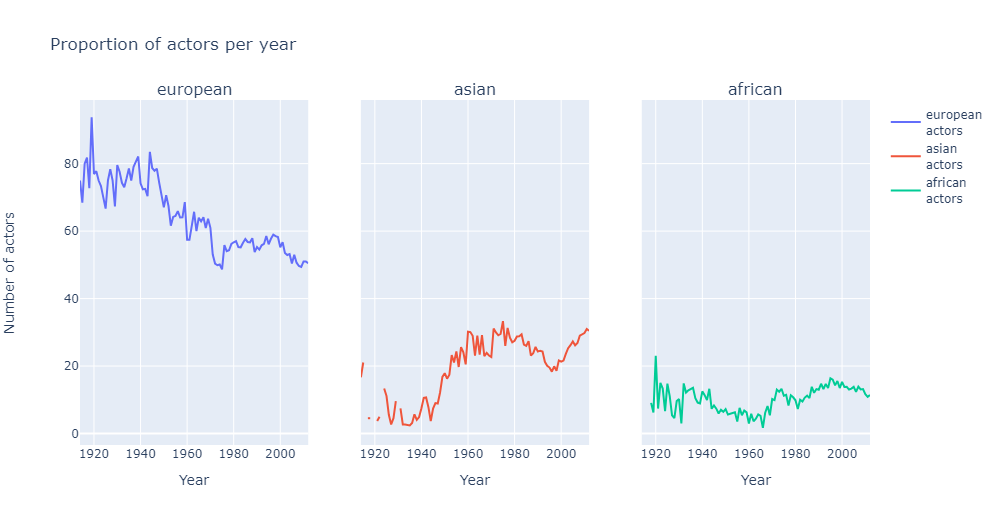

In [142]:
# Extract the top 4 ethnicities based on the counts
top_4_ethnicities = ethnicity_counts[1:4]

length = len(top_4_ethnicities)

# Removing missing values for analysis
actor_ethnicity_year = actor_ethnicity_year[actor_ethnicity_year['Actor ethnicity (reduced)'] != 'missing']
nb_actors_per_year = actor_ethnicity_year.groupby(['Year']).size()

# Create subplots for each of the top 4 ethnicities
fig = make_subplots(rows=1, cols=length, subplot_titles=top_4_ethnicities['Ethnicity'].values, shared_yaxes=True)

# Iterate through the top 4 ethnicities and plot the number of actors per year for each ethnicity
for idx, eth in enumerate(top_4_ethnicities['Ethnicity'].values):
    ethnicity_actors = actor_ethnicity_year[actor_ethnicity_year['Actor ethnicity (reduced)'] == eth]
    nb_ethnicity_actors_per_year = ethnicity_actors.groupby(['Year']).size()

    perc_ethnicity_actors_per_year = nb_ethnicity_actors_per_year / nb_actors_per_year * 100.0
    perc_ethnicity_actors_per_year = pd.DataFrame(perc_ethnicity_actors_per_year)
    perc_ethnicity_actors_per_year.reset_index(inplace=True)
    perc_ethnicity_actors_per_year.columns = ['Year','Proportion']
    # Add trace for the current ethnicity
    fig.add_trace(go.Scatter(x=perc_ethnicity_actors_per_year['Year'], y=perc_ethnicity_actors_per_year['Proportion'],
                             mode='lines', name=f"{eth}<br>actors"),
                  row=1, col=idx + 1)

    # Set the title and labels for each subplot
    fig.update_xaxes(title_text="Year", row=1, col=idx + 1)

fig.update_yaxes(title_text="Number of actors", row=1, col=idx + 1)

# Update the layout
fig.update_layout(title_text="Proportion of actors per year", showlegend=True)
fig.update_layout(width=1000)

# Save the figure
fig.write_html('htmls/actors_ethnicity_proportion.html')
fig.show()

Contrary to the count plots where we had an increase of number of actors for all the ethnicities, in these plots, we can see that the proportions of Indian actors and Jewish actors increase for some time, but then they start to decrease, which is something we could not predict from the previous plots.

Regarding the African actors, we can see clearly that there is a clear decrease in their proportion until around 1970, where we see the same sudden increase that could be a result of the Civil rights movement.

# Regression and Correlation
In order to validate the proposition that there is indeed a significant increase in the proportion of African-American actors, we apply linear regression on the proportion of Afircan-American actors during three intervals of time:
- Before the Civil rights movement (Before 1954)
- During the Civil rights movement (After 1954 and before 1968)
- After the Civil rights movement (After 1968)

In [144]:
ethnicity_actors = actor_ethnicity_year[actor_ethnicity_year['Actor ethnicity (reduced)'] == 'african']
nb_ethnicity_actors_per_year = ethnicity_actors.groupby(['Year']).size()

nb_actors_per_year = actor_ethnicity_year.groupby(['Year']).size()
perc_african_actors_per_year = nb_ethnicity_actors_per_year / nb_actors_per_year * 100.0
perc_african_actors_per_year = pd.DataFrame(perc_african_actors_per_year)
perc_african_actors_per_year.reset_index(inplace=True)
perc_african_actors_per_year.columns = ['Year','Proportion']

african_before_1954 = perc_african_actors_per_year[perc_african_actors_per_year['Year']<1954]
african_between = perc_african_actors_per_year[(perc_african_actors_per_year['Year']>=1954)&(perc_african_actors_per_year['Year']<=1968)]
african_after_1968 = perc_african_actors_per_year[perc_african_actors_per_year['Year']>1968]

african_before_1954 = african_before_1954.dropna(subset=['Proportion'])

# Create a scatter plot for the entire dataset
fig = px.scatter(perc_african_actors_per_year, x='Year', y='Proportion', labels={'Proportion': 'Proportion of African actors [%]'}, title='Proportion of African actors')

def plot_regression_and_pvalue(df, color, name):
    X = sm.add_constant(df['Year'])
    model = sm.OLS(df['Proportion'], X).fit()
    p_value = model.pvalues['Year']

    # Print regression summary
    print(f"Regression Results for {name}:")
    print(model.summary(), "\n")

    # Plot regression line
    fig.add_trace(go.Scatter(x=df['Year'], y=model.fittedvalues, mode='lines', line=dict(color=color), name=f'{name}'))

# Plot regression lines for each period
plot_regression_and_pvalue(african_before_1954, 'red', 'Before the Civil rights movement')
plot_regression_and_pvalue(african_between, 'orange', 'During the Civil rights movement')
plot_regression_and_pvalue(african_after_1968, 'green', 'After the Civil rights movement')

Regression Results for Before the Civil rights movement:
                            OLS Regression Results                            
Dep. Variable:             Proportion   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     6.341
Date:                Thu, 21 Dec 2023   Prob (F-statistic):             0.0165
Time:                        15:17:11   Log-Likelihood:                -99.965
No. Observations:                  37   AIC:                             203.9
Df Residuals:                      35   BIC:                             207.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



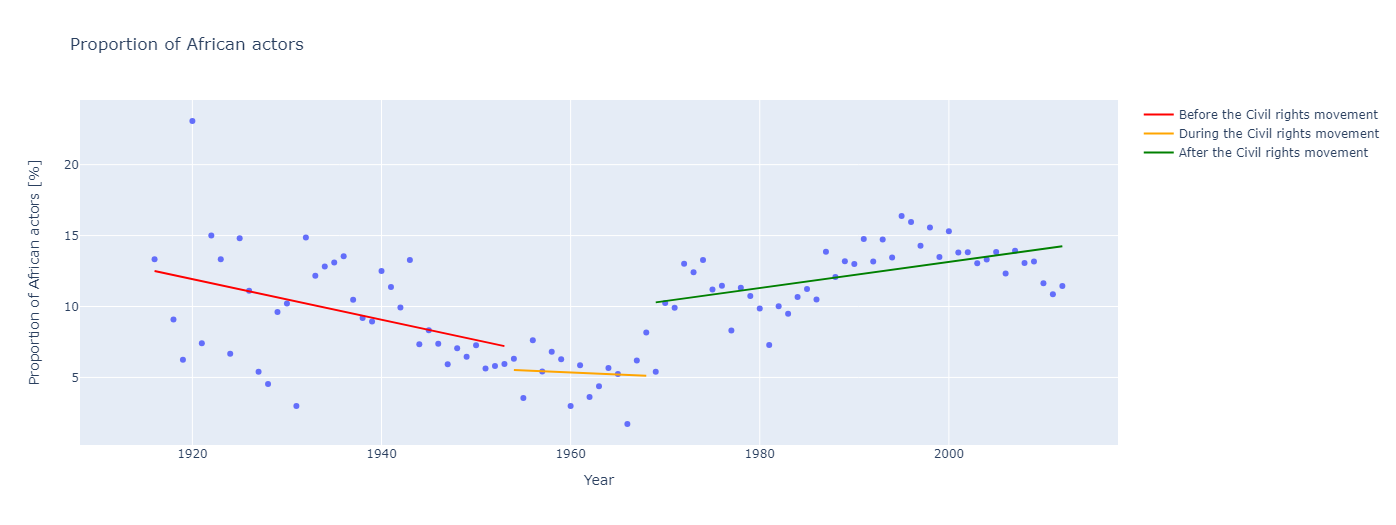

In [143]:
# Update layout
fig.update_layout(xaxis_title='Year', yaxis_title='Proportion of African actors [%]')

# Show plot
fig.show()
fig.write_html('htmls/african_actors_perc.html')

In [96]:
# Calculate Pearson Coefficient for After Civil rights movement
print(stats.pearsonr(african_after_1968['Year'],african_after_1968['Proportion']))

PearsonRResult(statistic=0.7817176081875327, pvalue=3.7636600530946404e-10)


From the plot above, we can see that before the Civil rights movement, the proportion of African actors decreases, but we have a relatively high variance maybe indicating that this trend is not exact.

Moreover, we can see that during the Civil rights movement, we have a transition period with a nearly-horizontal line.

Most importantly, after the Civil rights movement, we can see a clear increase in the proportion of African actors. Moreover, calculating the Pearson Coefficient (for values after the Civil rights movement) tells us that the correlation is statistically-significant (with a p-value<0.05).

It is important to note that this analysis does not prove causality, i.e. this does not prove that the Civil rights movement is the reason for this increase. Several confounders could play a role in having this increase.

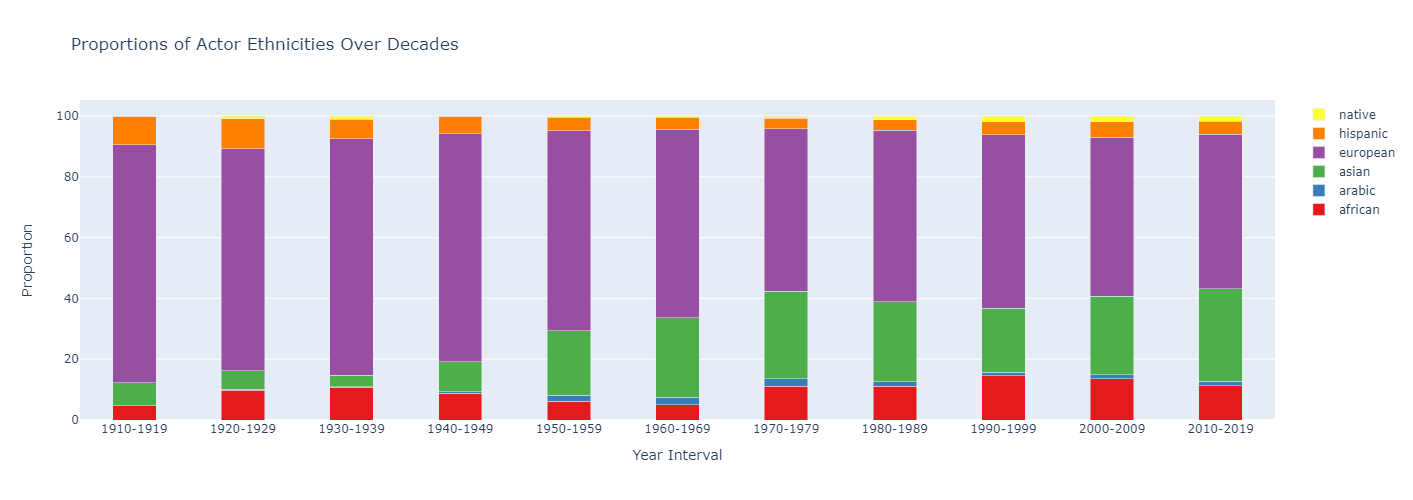

In [145]:
bins = list(range(1910, 2021, 10))
labels = [f"{i}-{i+9}" for i in range(1910, 2020, 10)]
actor_ethnicity_year['YearInterval'] = pd.cut(actor_ethnicity_year['Year'], bins=bins, labels=labels, right=False)

# Create a cross-tabulation of the data and calculate proportions
cross_tab = pd.crosstab(index=actor_ethnicity_year['YearInterval'],
                        columns=actor_ethnicity_year['Actor ethnicity (reduced)'],
                        normalize='index') * 100.0

# Create a list of colors for each ethnicity
colors = px.colors.qualitative.Set1

# Create a list of traces for each ethnicity
traces = []
for ethnicity, color in zip(cross_tab.columns, colors):
    trace = go.Bar(
        x=cross_tab.index,
        y=cross_tab[ethnicity],
        name=ethnicity,
        marker=dict(color=color),
        width=0.4
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Proportions of Actor Ethnicities Over Decades',
    xaxis=dict(title='Year Interval'),
    yaxis=dict(title='Proportion'),
    barmode='stack',
    bargap=0.15
)

# Create the figure and add traces
fig = go.Figure(data=traces, layout=layout)
fig.update_layout(height=500)

# Save the figure
fig.write_html('htmls/Ethnicities_Over_Decades.html')
fig.show()

### Ethnicities of well-recognized actors

#### Distribution of ethnicities for actors with highest recognition
As we did before, we will select the 10%-most recognized actors and explore their ethnicities

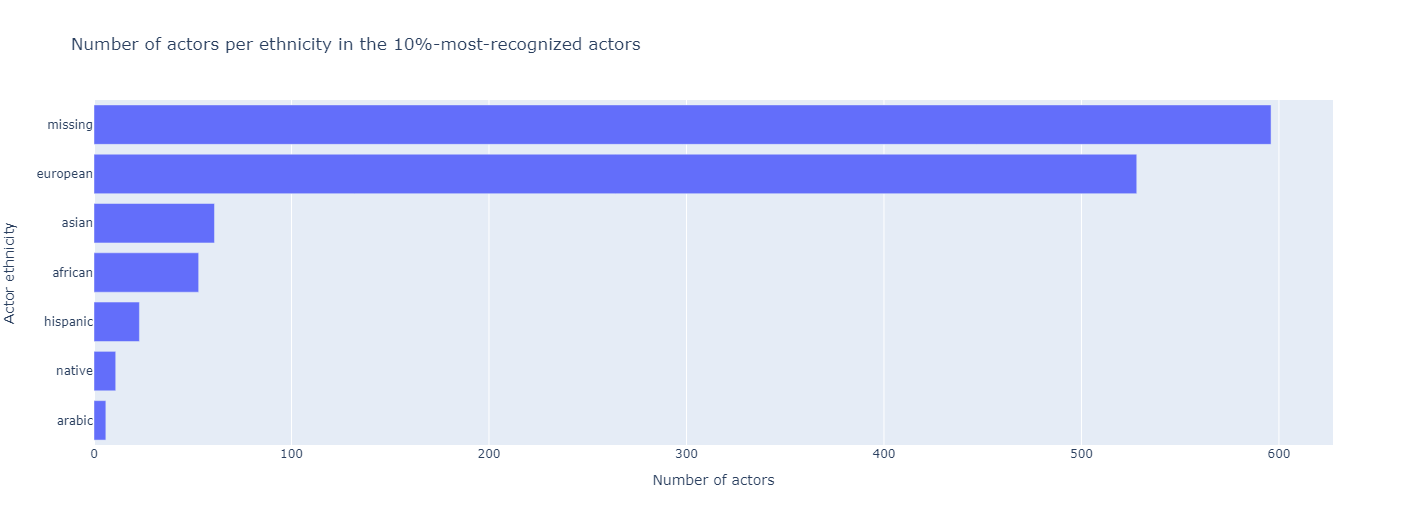

In [146]:
# Filter and count the number of actors per ethnicity
ethnicity_most_recog = general_recog_ethnicity[:1278].groupby(['Actor ethnicity (reduced)']).size()
ethnicity_most_recog = ethnicity_most_recog[ethnicity_most_recog > 2]

# Sort the values in descending order
ethnicity_most_recog = ethnicity_most_recog.sort_values(ascending=False)

# Create a horizontal bar chart with Plotly
fig = px.bar(
    x=ethnicity_most_recog.values,
    y=ethnicity_most_recog.index,
    orientation='h',  # 'h' for horizontal bars
    labels={'x': 'Number of actors', 'y': 'Actor ethnicity'},
    title='Number of actors per ethnicity in the 10%-most-recognized actors',
)

# Update layout for better appearance
fig.update_layout(yaxis=dict(categoryorder='total ascending'))

# Save the figure
fig.write_html('htmls/ethnicity_10perc_hist.html')
fig.show()

In the plots above, we can see that the distribution of Recognition coefficients for every ethnicity is right-skewed.

#### Evolution of mean recognition for a specific ethnicity per year

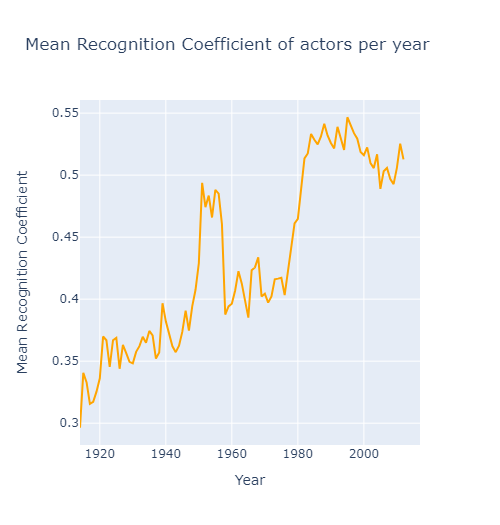

In [147]:
# Group the data by year and calculate the total number of actors per year
ethnicity_recog = actor_ethnicity_year.groupby(['Year'])['Recognition Coefficient'].mean()
ethnicity_recog=ethnicity_recog.reset_index()
# Create a Plotly figure for the total number of actors per year
fig_total_actors = px.line(ethnicity_recog, x='Year', y='Recognition Coefficient',
                           title='Mean Recognition Coefficient of actors per year',
                           labels={'Recognition Coefficient': 'Mean Recognition Coefficient', 'Year': 'Year'},
                           range_x=[1914, 2017])

# Update the line color in the layout
fig_total_actors.update_traces(line=dict(color='orange'))
fig_total_actors.update_layout(width=500)

# Save and show the figure
fig_total_actors.write_html('htmls/recognition_ethnicities.html')
fig_total_actors.show()

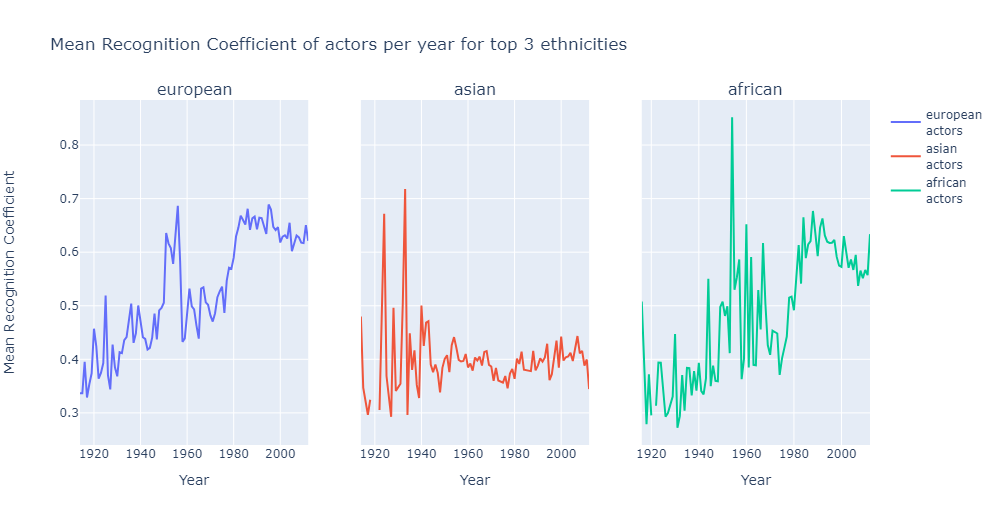

In [148]:
# Extract the top 4 ethnicities based on the counts
top_4_ethnicities = ethnicity_counts[1:4]

# Create subplots for each of the top 4 ethnicities
fig = make_subplots(rows=1, cols=len(top_4_ethnicities), subplot_titles=top_4_ethnicities['Ethnicity'].values, shared_yaxes=True)

# Iterate through the top 4 ethnicities and plot the number of actors per year for each ethnicity
for idx, eth in enumerate(top_4_ethnicities['Ethnicity'].values):
    # Filter data for the current ethnicity
    ethnicity_people = actor_ethnicity_year[actor_ethnicity_year['Actor ethnicity (reduced)'] == eth]
    ethnicity_recog = ethnicity_people.groupby(['Year'])['Recognition Coefficient'].mean()
    ethnicity_recog = ethnicity_recog.reset_index()

    # Add trace for the current ethnicity
    fig.add_trace(go.Scatter(x=ethnicity_recog['Year'], y=ethnicity_recog['Recognition Coefficient'],
                             mode='lines', name=f"{eth}<br>actors"),
                  row=1, col=idx + 1,
                  )

    # Set the title and labels for each subplot
    fig.update_xaxes(title_text="Year", row=1, col=idx + 1)

fig.update_yaxes(title_text="Mean Recognition Coefficient", row=1, col=idx + 1)

# Update the layout
fig.update_layout(title_text="Mean Recognition Coefficient of actors per year for top 3 ethnicities", showlegend=True)
fig.update_layout(width=1000)

# Save and show the figure
fig.write_html('htmls/recognition_ethnicities_3.html')
fig.show()

The following plots suggest that with time, African actors have bigger mean recognition coefficients, suggesting that they are getting more recognized.

### Evolution of Mean Importance of African Actors

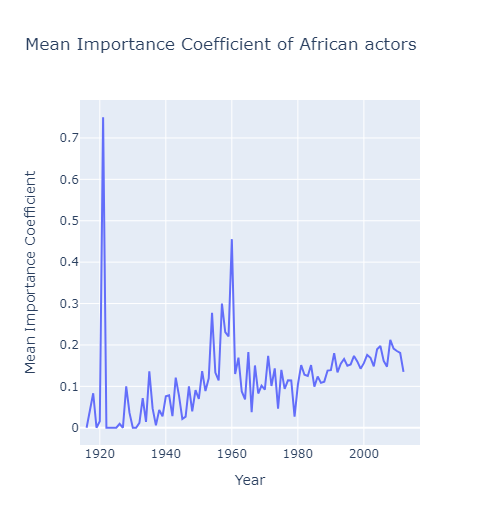

In [149]:
importance_ethnicity = pd.merge(actor_popularity_movie_coef, general_recog_ethnicity[['Actor Name','Actor ethnicity (reduced)']],how='left')
importance_ethnicity_grouped = importance_ethnicity[['Actor ethnicity (reduced)','Year','Importance Coefficient']].groupby(by=['Actor ethnicity (reduced)','Year']).mean()
importance_ethnicity_grouped = importance_ethnicity_grouped.reset_index()
pp = importance_ethnicity_grouped[importance_ethnicity_grouped['Actor ethnicity (reduced)']=='african'].drop(columns='Actor ethnicity (reduced)')

fig = px.line(pp, x='Year', y='Importance Coefficient',title='Mean Importance Coefficient of African actors',
                           labels={'Importance Coefficient': 'Mean Importance Coefficient', 'Year': 'Year'},
                           range_x=[1914, 2017])

# Update the line color in the layout
fig.update_layout(width=500)

# Save and show the figure
fig.write_html('htmls/importance_african.html')
fig.show()

***


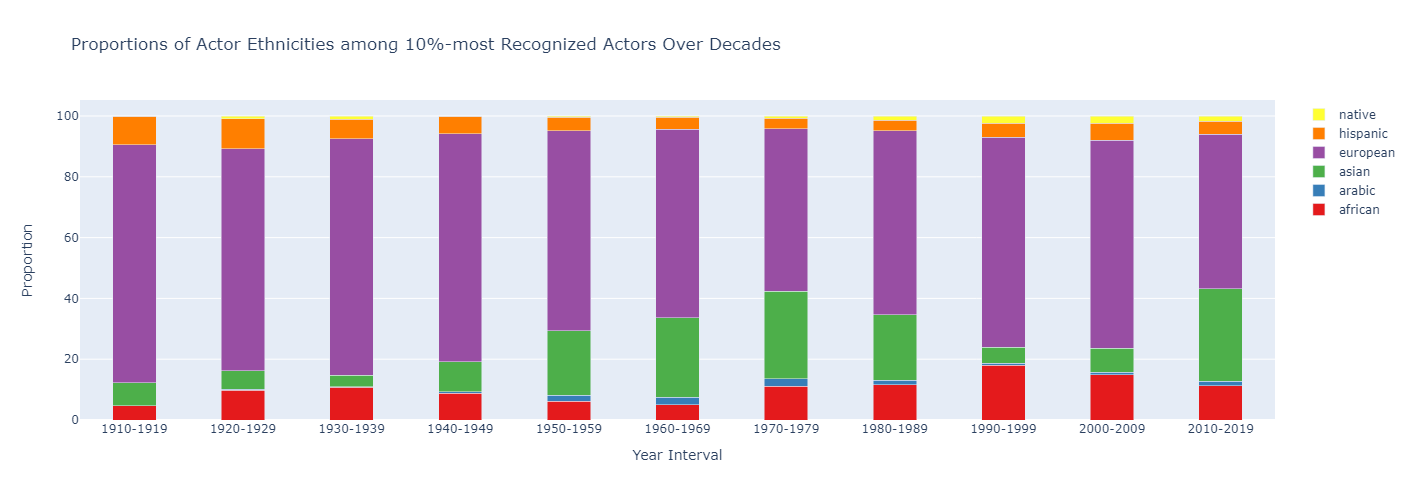

In [150]:
actor_ethnicity_decade = actor_ethnicity_year.copy(deep=True)
# Get the corresponding decade
actor_ethnicity_decade['Year'] = (actor_ethnicity_decade['Year'] // 5) * 5

df_sorted = actor_ethnicity_decade.groupby('YearInterval').apply(lambda x: x.sort_values('Recognition Coefficient', ascending=False))

top_10_percent = df_sorted.groupby(level=0).head(int(0.1 * len(df_sorted)))

top_10_percent_ = top_10_percent.reset_index(drop=True)

# Create a cross-tabulation of the data and calculate proportions
cross_tab = pd.crosstab(index=top_10_percent_['YearInterval'],
                        columns=top_10_percent_['Actor ethnicity (reduced)'],
                        normalize='index') * 100.0

# Create a list of colors for each ethnicity
colors = px.colors.qualitative.Set1

# Create a list of traces for each ethnicity
traces = []
for ethnicity, color in zip(cross_tab.columns, colors):
    trace = go.Bar(
        x=cross_tab.index,
        y=cross_tab[ethnicity],
        name=ethnicity,
        marker=dict(color=color),
        width=0.4
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Proportions of Actor Ethnicities among 10%-most Recognized Actors Over Decades',
    xaxis=dict(title='Year Interval'),
    yaxis=dict(title='Proportion'),
    barmode='stack',
    bargap=0.15
)

# Create the figure and add traces
fig = go.Figure(data=traces, layout=layout)
fig.update_layout(height=500)  # You can adjust the width as needed

# Save and show the figure
fig.write_html('htmls/recognized_Ethnicities_Over_Decades.html')
fig.show()